# **Projet 9. Produisez une étude de marché avec R ou Python**

## **Table des matières** 

* [Mission 1. Préparation et exploration des données](#chapter1)
    * [1. Importation des données](#section_1_1)
    * [2. Exploration des données](#section_1_2)
    * [3. Préparation des données](#section_1_3)
* [Mission 2. Clustering](#chapter2)
    * [1. Choix des variables](#section_2_1)
    * [2. Détermination du nombre de clusters](#section_2_2)
    * [3. Clustering](#section_2_3)
    * [4. Comparaison et sélection de clusters](#section_2_4)
* [Mission 3. Représentation des clusters](#chapter3)
    * [1. ACP](#section_3_1)
    * [2. Visualisation de la struction locale des données (t-SNE)](#section_3_2)
    * [3. Visualisation de la struction globale des données (MDS)](#section_3_3)
    * [4. Visualisation des clusters à l'aide d'une carte](#section_3_4)
* [Conclusion](#chapter4)

## **Bibliographie**

FAOSTAT (Food Balances, Prices, GDP) http://www.fao.org/faostat/fr/#data

Gravity with Gravitas: A Solution to the Border Puzzle by James E. Anderson and Eric van Wincoop (Gravity Model) https://www.nber.org/system/files/working_papers/w8079/w8079.pdf

CEPII (Distances Between Countries Database) http://www.cepii.fr/CEPII/en/bdd_modele/download.asp?id=6

ESCAP (Trade Cost Database) https://www.unescap.org/resources/escap-world-bank-trade-cost-database

WITS (Export Database) https://wits.worldbank.org/CountryProfile/en/Country/FRA/Year/2018/TradeFlow/Export/Partner/all/Product/01-05_Animal#

## **Mission 1. Préparation et exploration des données** <a class="anchor" id="chapter1"></a>

### **1. Importation des données**<a class="anchor" id="section_1_1"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn import metrics
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import decomposition
import plotly.express as px
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import display #affichage des tableaux

In [ ]:
#### Cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="black", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b', alpha=0.5)
            ax.set_aspect('equal')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

Car j'ai trouvé les données pour 2018, je vais les utiliser au lieu de ceux de l'année 2017. <br>
Les fichiers **"DisponibiliteViande_2008.csv"** et **"DisponibiliteViande_2018.csv"** contiennent uniquement l'information sur la consommation de viande. Il me semble intéressant de distinguer les pays qui préfèrent d'autres types de viandes et ne mangent quasiment pas de poulet (et vice versa).<br>
Il y a deux lignes pour chaque pays dans les fichiers **"DisponibiliteProteines_2008.csv"** et **"DisponibiliteProteines_2018.csv"** : <br>
&emsp;&emsp;Disponibilité de protéines en quantité (g/pers/jour) - Total General <br>
&emsp;&emsp;Disponibilité de protéines en quantité (g/pers/jour) - Produits Animaux<br>
Cette information nous permettra de calculer la proportion de protéines d'origine animale par rapport à la quantité totale de protéines.<br>
**"dist_cepii.csv"** contient les distances entre la France et tous les autres pays en kilomètres.<br>
Le fichier **"france_trade_costs_2018.csv"** contient les coûts commerciaux équivalents ad valorem de produits agricoles pour la France (en d'autres termes, si le "Trcost from France" = 418 pour l'Afghanistan le commerce de produits agricoles entre la France et l'Afghanistan implique, en moyenne pour tous les produits agricoles échangeables, des coûts supplémentaires s'élevant à environ 418% de la valeur des biens - par rapport au moment où les deux pays échangent ces marchandises à l'intérieur de leurs frontières) et les exportations de produits d'origine animale de France par pays pour 2018 (en milliers US dollars). <br>
Le fichier **"countries_fr_eng.csv"** est un dictionnaire anglais-français contenant les noms de pays que l'on va analyser.<br>
Enfin, les fichiers **"Population_2000_2018.csv"** et **"PIB_2018.csv"** contiennent l'information sur la population (en milliers) et le PIB (total (en milliers) et par habitant) par pays.

In [ ]:
# bilan alimentaire de la consommation de viande pour tous les pays
meat_2008=pd.read_csv('DisponibiliteViande_2008.csv', header=0)
meat_2018=pd.read_csv('DisponibiliteViande_2018.csv', header=0)
# bilan alimentaire de la consommation de protéines (produits animaux + general) pour tous les pays
prot_2008=pd.read_csv('DisponibiliteProteines_2008.csv', header=0)
prot_2018=pd.read_csv('DisponibiliteProteines_2018.csv', header=0)
# population
population=pd.read_csv('Population_2000_2018.csv', header=0)
# distances entre la France et tous les autres pays
distance=pd.read_csv('dist_cepii.csv', header=0)
# PIB (total + par habitant)
pib=pd.read_csv('PIB_2018.csv', header=0)
# coûts de l'exportations de France aux autres pays
tariff=pd.read_csv('france_trade_costs_2018.csv', header=0)
# dictionnaire : les nom de pays en français et en anglais
countries_trans=pd.read_csv('countries_fr_eng.csv', header=0)

### **2. Exploration des données**<a class="anchor" id="section_1_2"></a>

### Les tableaux meat_2008 et meat_2018 :
**Nombre de lignes et de colonnes :** meat_2008 - 8 162 lignes et 14 colonnes ;  meat_2018 - 9 846 lignes et 14 colonnes
<br>
**Variables inutiles (unique=1 ou les colonnes répétitives) :** Code Domaine, Domaine, Code zone (FAO), Code Élément, Code Produit, Code année, Année, Unité, Symbole, Description du Symbole
<br>
**Type de variables utiles :** quantitative (Valeur), qualitatives (Zone, Élément, Produit)
<br>
&emsp;&emsp;Variable Valeur : la signification de cette variable dépend de la colonne Élément  <br>
&emsp;&emsp;Variable Élément : on a 14 valeurs uniques; 4 correspondent à la disponibilité alimentaire, 10 précisent les utilisations/moyens d’acquisition de la disponibilité alimentaire  <br>
&emsp;&emsp;Variable Produit : dans cette colonne on a 5 produits différents (des catégories de viande), Viande d'Ovins/Caprins, Viande de Bovins, Viande de Volailles, Viande de porcins, Viande, Autre<br>
&emsp;&emsp;Variable Zone : nous avons des données pour 172 pays <br>
**Analyse des valeurs manquantes :** aucune

In [ ]:
meat_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8162 entries, 0 to 8161
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            8162 non-null   object 
 1   Domaine                 8162 non-null   object 
 2   Code zone (FAO)         8162 non-null   int64  
 3   Zone                    8162 non-null   object 
 4   Code Élément            8162 non-null   int64  
 5   Élément                 8162 non-null   object 
 6   Code Produit            8162 non-null   int64  
 7   Produit                 8162 non-null   object 
 8   Code année              8162 non-null   int64  
 9   Année                   8162 non-null   int64  
 10  Unité                   8162 non-null   object 
 11  Valeur                  8162 non-null   float64
 12  Symbole                 8162 non-null   object 
 13  Description du Symbole  8162 non-null   object 
dtypes: float64(1), int64(5), object(8)
memor

In [ ]:
meat_2008.describe(include='all')

Code Domaine                                            Domaine  \
count          8162                                               8162   
unique            1                                                  1   
top            FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
freq           8162                                               8162   
mean            NaN                                                NaN   
std             NaN                                                NaN   
min             NaN                                                NaN   
25%             NaN                                                NaN   
50%             NaN                                                NaN   
75%             NaN                                                NaN   
max             NaN                                                NaN   

        Code zone (FAO)                   Zone  Code Élément  \
count       8162.000000                   8162   8162.000000   
unique              NaN                    172           NaN   
top                 NaN  États-Unis d'Amérique           NaN   
freq                NaN                     58           NaN   
mean         126.220289                    NaN   3434.033448   
std           71.947444                    NaN   2357.678328   
min            1.000000                    NaN    645.000000   
25%           67.000000                    NaN    674.000000   
50%          121.000000                    NaN   5142.000000   
75%          188.000000                    NaN   5511.000000   
max          273.000000                    NaN   5911.000000   

                         Élément  Code Produit           Produit  Code année  \
count                       8162   8162.000000              8162      8162.0   
unique                        14           NaN                 5         NaN   
top     Disponibilité intérieure           NaN  Viande de Bovins         NaN   
freq                         858           NaN              1724         NaN   
mean                         NaN   2732.985298               NaN      2008.0   
std                          NaN      1.421397               NaN         0.0   
min                          NaN   2731.000000               NaN      2008.0   
25%                          NaN   2732.000000               NaN      2008.0   
50%                          NaN   2733.000000               NaN      2008.0   
75%                          NaN   2734.000000               NaN      2008.0   
max                          NaN   2735.000000               NaN      2008.0   

         Année               Unité        Valeur Symbole  \
count   8162.0                8162   8162.000000    8162   
unique     NaN                   4           NaN       2   
top        NaN  Milliers de tonnes           NaN       S   
freq       NaN                4745           NaN    4745   
mean    2008.0                 NaN    118.038264     NaN   
std        0.0                 NaN   1081.609457     NaN   
min     2008.0                 NaN    -28.000000     NaN   
25%     2008.0                 NaN      0.232500     NaN   
50%     2008.0                 NaN      4.000000     NaN   
75%     2008.0                 NaN     26.000000     NaN   
max     2008.0                 NaN  45133.000000     NaN   

       Description du Symbole  
count                    8162  
unique                      2  
top     Données standardisées  
freq                     4745  
mean                      NaN  
std                       NaN  
min                       NaN  
25%                       NaN  
50%                       NaN  
75%                       NaN  
max                       NaN

In [ ]:
meat_2008.head(5)

Code Domaine                                            Domaine  \
0         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
1         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
2         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
3         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
4         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   

   Code zone (FAO)         Zone  Code Élément  \
0                2  Afghanistan          5511   
1                2  Afghanistan          5611   
2                2  Afghanistan          5301   
3                2  Afghanistan          5142   
4                2  Afghanistan           645   

                                             Élément  Code Produit  \
0                                         Production          2731   
1                            Importations - Quantité          2731   
2                           Disponibilité intérieure          2731   
3                                         Nourriture          2731   
4  Disponibilité alimentaire en quantité (kg/pers...          2731   

            Produit  Code année  Année               Unité  Valeur Symbole  \
0  Viande de Bovins        2008   2008  Milliers de tonnes  133.00       S   
1  Viande de Bovins        2008   2008  Milliers de tonnes    1.00       S   
2  Viande de Bovins        2008   2008  Milliers de tonnes  134.00       S   
3  Viande de Bovins        2008   2008  Milliers de tonnes  134.00       S   
4  Viande de Bovins        2008   2008                  kg    4.97      Fc   

  Description du Symbole  
0  Données standardisées  
1  Données standardisées  
2  Données standardisées  
3  Données standardisées  
4        Donnée calculée

### Les tableaux prot_2008 et prot_2018 :
**Nombre de lignes et de colonnes :** 344 lignes et 14 colonnes
<br>
**Variables inutiles (unique=1 ou les colonnes répétitives) :** Code Domaine, Domaine, Code zone (FAO), Code Élément, Élément, Code Produit, Code année, Année, Unité, Symbole, Description du Symbole
<br>
**Type de variables utiles :** quantitative (Valeur), qualitatives (Zone, Produit)
<br>
&emsp;&emsp;Variable Valeur : disponibilité de protéines en quantité (g/pers/jour), la signification de cette colonne dépend de la colonne Produit (Total General / Produits Animaux) <br>
&emsp;&emsp;Variable Produit : dans cette colonne on a 2 valeurs - Total General et Produits Animaux <br>
&emsp;&emsp;Variable Zone : nous avons des données pour 172 pays <br>
**Analyse des valeurs manquantes :** aucune

In [ ]:
prot_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            344 non-null    object 
 1   Domaine                 344 non-null    object 
 2   Code zone (FAO)         344 non-null    int64  
 3   Zone                    344 non-null    object 
 4   Code Élément            344 non-null    int64  
 5   Élément                 344 non-null    object 
 6   Code Produit            344 non-null    int64  
 7   Produit                 344 non-null    object 
 8   Code année              344 non-null    int64  
 9   Année                   344 non-null    int64  
 10  Unité                   344 non-null    object 
 11  Valeur                  344 non-null    float64
 12  Symbole                 344 non-null    object 
 13  Description du Symbole  344 non-null    object 
dtypes: float64(1), int64(5), object(8)
memory 

In [ ]:
prot_2008.describe(include='all')

Code Domaine                                            Domaine  \
count           344                                                344   
unique            1                                                  1   
top            FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
freq            344                                                344   
mean            NaN                                                NaN   
std             NaN                                                NaN   
min             NaN                                                NaN   
25%             NaN                                                NaN   
50%             NaN                                                NaN   
75%             NaN                                                NaN   
max             NaN                                                NaN   

        Code zone (FAO)     Zone  Code Élément  \
count        344.000000      344         344.0   
unique              NaN      172           NaN   
top                 NaN  Bahamas           NaN   
freq                NaN        2           NaN   
mean         126.232558      NaN         674.0   
std           72.225299      NaN           0.0   
min            1.000000      NaN         674.0   
25%           66.750000      NaN         674.0   
50%          121.500000      NaN         674.0   
75%          188.250000      NaN         674.0   
max          273.000000      NaN         674.0   

                                                  Élément  Code Produit  \
count                                                 344    344.000000   
unique                                                  1           NaN   
top     Disponibilité de protéines en quantité (g/pers...           NaN   
freq                                                  344           NaN   
mean                                                  NaN   2921.000000   
std                                                   NaN     20.029133   
min                                                   NaN   2901.000000   
25%                                                   NaN   2901.000000   
50%                                                   NaN   2921.000000   
75%                                                   NaN   2941.000000   
max                                                   NaN   2941.000000   

                 Produit  Code année   Année            Unité      Valeur  \
count                344       344.0   344.0              344  344.000000   
unique                 2         NaN     NaN                1         NaN   
top     Produits Animaux         NaN     NaN  g/personne/jour         NaN   
freq                 172         NaN     NaN              344         NaN   
mean                 NaN      2008.0  2008.0              NaN   57.700959   
std                  NaN         0.0     0.0              NaN   29.761190   
min                  NaN      2008.0  2008.0              NaN    5.190000   
25%                  NaN      2008.0  2008.0              NaN   33.110000   
50%                  NaN      2008.0  2008.0              NaN   58.305000   
75%                  NaN      2008.0  2008.0              NaN   79.787500   
max                  NaN      2008.0  2008.0              NaN  134.230000   

       Symbole Description du Symbole  
count      344                    344  
unique       1                      1  
top         Fc        Donnée calculée  
freq       344                    344  
mean       NaN                    NaN  
std        NaN                    NaN  
min        NaN                    NaN  
25%        NaN                    NaN  
50%        NaN                    NaN  
75%        NaN                    NaN  
max        NaN                    NaN

In [ ]:
prot_2008.head(5)

Code Domaine                                            Domaine  \
0         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
1         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
2         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
3         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   
4         FBSH  Bilans Alimentaire (Ancienne méthodologie et p...   

   Code zone (FAO)            Zone  Code Élément  \
0                2     Afghanistan           674   
1                2     Afghanistan           674   
2              202  Afrique du Sud           674   
3              202  Afrique du Sud           674   
4                3         Albanie           674   

                                             Élément  Code Produit  \
0  Disponibilité de protéines en quantité (g/pers...          2901   
1  Disponibilité de protéines en quantité (g/pers...          2941   
2  Disponibilité de protéines en quantité (g/pers...          2901   
3  Disponibilité de protéines en quantité (g/pers...          2941   
4  Disponibilité de protéines en quantité (g/pers...          2901   

            Produit  Code année  Année            Unité  Valeur Symbole  \
0     Total General        2008   2008  g/personne/jour   56.96      Fc   
1  Produits Animaux        2008   2008  g/personne/jour   11.80      Fc   
2     Total General        2008   2008  g/personne/jour   81.18      Fc   
3  Produits Animaux        2008   2008  g/personne/jour   33.22      Fc   
4     Total General        2008   2008  g/personne/jour  101.95      Fc   

  Description du Symbole  
0        Donnée calculée  
1        Donnée calculée  
2        Donnée calculée  
3        Donnée calculée  
4        Donnée calculée

### Le tableau population :
**Nombre de lignes et de colonnes :** 4 411 lignes et 15 colonnes
<br>
**Variables inutiles (unique=1 ou les colonnes répétitives) :** Code Domaine, Domaine, Code zone, Code Élément, Élément, Code Produit, Produit, Code année, Unité, Symbole, Description du Symbole, Note
<br>
**Type de variables utiles :** quantitative (Valeur), qualitative (Zone), date (Année)
<br>
&emsp;&emsp;Variable Valeur : population (en milliers) du pays correspondant, varie de 5,2 à 134,2 mille personnes <br>
&emsp;&emsp;Variable Années : nous avons données pour la péroide de 2009 à 2018 <br>
&emsp;&emsp;Variable Zone : nous avons des données pour 172 pays <br>
**Analyse des valeurs manquantes :** il y a 4 153 valeurs manquantes dans la colonne Note, on va supprimer cette colonne, car elle ne contient aucune information utile

In [ ]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [ ]:
population.describe(include='all')

Code Domaine                       Domaine    Code zone           Zone  \
count          4411                          4411  4411.000000           4411   
unique            1                             1          NaN            237   
top              OA  Séries temporelles annuelles          NaN  Îles Caïmanes   
freq           4411                          4411          NaN             19   
mean            NaN                           NaN   132.202902            NaN   
std             NaN                           NaN    75.854840            NaN   
min             NaN                           NaN     1.000000            NaN   
25%             NaN                           NaN    68.000000            NaN   
50%             NaN                           NaN   132.000000            NaN   
75%             NaN                           NaN   195.000000            NaN   
max             NaN                           NaN   299.000000            NaN   

        Code Élément            Élément  Code Produit                 Produit  \
count         4411.0               4411        4411.0                    4411   
unique           NaN                  1           NaN                       1   
top              NaN  Population totale           NaN  Population-Estimations   
freq             NaN               4411           NaN                    4411   
mean           511.0                NaN        3010.0                     NaN   
std              0.0                NaN           0.0                     NaN   
min            511.0                NaN        3010.0                     NaN   
25%            511.0                NaN        3010.0                     NaN   
50%            511.0                NaN        3010.0                     NaN   
75%            511.0                NaN        3010.0                     NaN   
max            511.0                NaN        3010.0                     NaN   

         Code année        Année           Unité        Valeur Symbole  \
count   4411.000000  4411.000000            4411  4.411000e+03    4411   
unique          NaN          NaN               1           NaN       2   
top             NaN          NaN  1000 personnes           NaN       X   
freq            NaN          NaN            4411           NaN    4374   
mean    2009.068238  2009.068238             NaN  2.963004e+04     NaN   
std        5.481539     5.481539             NaN  1.238029e+05     NaN   
min     2000.000000  2000.000000             NaN  7.850000e-01     NaN   
25%     2004.000000  2004.000000             NaN  3.921890e+02     NaN   
50%     2009.000000  2009.000000             NaN  4.764741e+03     NaN   
75%     2014.000000  2014.000000             NaN  1.821548e+04     NaN   
max     2018.000000  2018.000000             NaN  1.427648e+06     NaN   

               Description du Symbole  \
count                            4411   
unique                              2   
top     Sources internationales sûres   
freq                             4374   
mean                              NaN   
std                               NaN   
min                               NaN   
25%                               NaN   
50%                               NaN   
75%                               NaN   
max                               NaN   

                                                     Note  
count                                                 258  
unique                                                  1  
top     UNDESA, Population Division – World Population...  
freq                                                  258  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                

In [ ]:
population.head(5)

Code Domaine                       Domaine  Code zone         Zone  \
0           OA  Séries temporelles annuelles          2  Afghanistan   
1           OA  Séries temporelles annuelles          2  Afghanistan   
2           OA  Séries temporelles annuelles          2  Afghanistan   
3           OA  Séries temporelles annuelles          2  Afghanistan   
4           OA  Séries temporelles annuelles          2  Afghanistan   

   Code Élément            Élément  Code Produit                 Produit  \
0           511  Population totale          3010  Population-Estimations   
1           511  Population totale          3010  Population-Estimations   
2           511  Population totale          3010  Population-Estimations   
3           511  Population totale          3010  Population-Estimations   
4           511  Population totale          3010  Population-Estimations   

   Code année  Année           Unité     Valeur Symbole  \
0        2000   2000  1000 personnes  20779.953       X   
1        2001   2001  1000 personnes  21606.988       X   
2        2002   2002  1000 personnes  22600.770       X   
3        2003   2003  1000 personnes  23680.871       X   
4        2004   2004  1000 personnes  24726.684       X   

          Description du Symbole Note  
0  Sources internationales sûres  NaN  
1  Sources internationales sûres  NaN  
2  Sources internationales sûres  NaN  
3  Sources internationales sûres  NaN  
4  Sources internationales sûres  NaN

### Le tableau distance :
**Nombre de lignes et de colonnes :** 172 lignes et 2 colonnes
<br>
**Type de variables :** quantitative (Distance), qualitative (Zone)
<br>
&emsp;&emsp;Variable Distance : les distances entre la France et les autres pays (en kilomètres), varie de 262 à 19264 km <br>
&emsp;&emsp;Variable Zone : nous avons des données pour 172 pays <br>
**Analyse des valeurs manquantes :** aucune

In [ ]:
distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Zone      172 non-null    object 
 1   Distance  172 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
distance.describe(include='all')

Zone      Distance
count       172    172.000000
unique      172           NaN
top     Bahamas           NaN
freq          1           NaN
mean        NaN   6028.448106
std         NaN   3954.255487
min         NaN    262.384500
25%         NaN   2434.689500
50%         NaN   5588.980500
75%         NaN   8768.391000
max         NaN  19263.880000

In [ ]:
distance.head(5)

Zone   Distance
0     Afghanistan  1603.5340
1  Afrique du Sud  9353.5520
2         Albanie  1603.5340
3         Algérie  1340.3900
4       Allemagne   439.8984

### Le tableau pib :
**Nombre de lignes et de colonnes :** 416 lignes et 15 colonnes
<br>
**Variables inutiles (unique=1 ou les colonnes répétitives) :** Code Domaine, Domaine, Code zone (FAO), Code Élément, Code Produit, Produit, Code année, Année, Unité, Symbole, Description du Symbole, Note
<br>
**Type de variables utiles :** quantitative (Valeur), qualitatives (Zone, Élément)
<br>
&emsp;&emsp;Variable Valeur : la signification de cette colonne dépend de la colonne Élément <br>
&emsp;&emsp;Variable Élément : dans cette colonne on a 2 valeurs - Valeur US dollars (PIB total) et Valeur US dollars par habitant (PIB/hab)  <br>
&emsp;&emsp;Variable Zone : nous avons des données pour 172 pays <br>
**Analyse des valeurs manquantes :** la colonne Note est vide, on va la supprimer

In [ ]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            416 non-null    object 
 1   Domaine                 416 non-null    object 
 2   Code zone (FAO)         416 non-null    int64  
 3   Zone                    416 non-null    object 
 4   Code Élément            416 non-null    int64  
 5   Élément                 416 non-null    object 
 6   Code Produit            416 non-null    int64  
 7   Produit                 416 non-null    object 
 8   Code année              416 non-null    int64  
 9   Année                   416 non-null    int64  
 10  Unité                   416 non-null    object 
 11  Valeur                  416 non-null    float64
 12  Symbole                 416 non-null    object 
 13  Description du Symbole  416 non-null    object 
 14  Note                    0 non-null      fl

In [ ]:
pib.describe(include='all')

Code Domaine            Domaine  Code zone (FAO)           Zone  \
count           416                416       416.000000            416   
unique            1                  1              NaN            208   
top              MK  Indicateurs macro              NaN  Îles Caïmanes   
freq            416                416              NaN              2   
mean            NaN                NaN       132.139423            NaN   
std             NaN                NaN        75.981322            NaN   
min             NaN                NaN         1.000000            NaN   
25%             NaN                NaN        67.750000            NaN   
50%             NaN                NaN       130.500000            NaN   
75%             NaN                NaN       195.250000            NaN   
max             NaN                NaN       299.000000            NaN   

        Code Élément      Élément  Code Produit                 Produit  \
count     416.000000          416         416.0                     416   
unique           NaN            2           NaN                       1   
top              NaN  Valeur US $           NaN  Produit Intérieur Brut   
freq             NaN          208           NaN                     416   
mean     6114.500000          NaN       22008.0                     NaN   
std         4.505418          NaN           0.0                     NaN   
min      6110.000000          NaN       22008.0                     NaN   
25%      6110.000000          NaN       22008.0                     NaN   
50%      6114.500000          NaN       22008.0                     NaN   
75%      6119.000000          NaN       22008.0                     NaN   
max      6119.000000          NaN       22008.0                     NaN   

        Code année   Année Unité        Valeur Symbole  \
count        416.0   416.0   416  4.160000e+02     416   
unique         NaN     NaN     2           NaN       1   
top            NaN     NaN   US$           NaN       X   
freq           NaN     NaN   208           NaN     416   
mean        2018.0  2018.0   NaN  2.156778e+05     NaN   
std            0.0     0.0   NaN  1.293017e+06     NaN   
min         2018.0  2018.0   NaN  4.603914e+01     NaN   
25%         2018.0  2018.0   NaN  3.127245e+03     NaN   
50%         2018.0  2018.0   NaN  1.319363e+04     NaN   
75%         2018.0  2018.0   NaN  5.178272e+04     NaN   
max         2018.0  2018.0   NaN  2.061186e+07     NaN   

               Description du Symbole  Note  
count                             416   0.0  
unique                              1   NaN  
top     Sources internationales sûres   NaN  
freq                              416   NaN  
mean                              NaN   NaN  
std                               NaN   NaN  
min                               NaN   NaN  
25%                               NaN   NaN  
50%                               NaN   NaN  
75%                               NaN   NaN  
max                               NaN   NaN

In [ ]:
pib.head(5)

Code Domaine            Domaine  Code zone (FAO)            Zone  \
0           MK  Indicateurs macro                2     Afghanistan   
1           MK  Indicateurs macro                2     Afghanistan   
2           MK  Indicateurs macro              202  Afrique du Sud   
3           MK  Indicateurs macro              202  Afrique du Sud   
4           MK  Indicateurs macro                3         Albanie   

   Code Élément                   Élément  Code Produit  \
0          6110               Valeur US $         22008   
1          6119  Valeur US $ par habitant         22008   
2          6110               Valeur US $         22008   
3          6119  Valeur US $ par habitant         22008   
4          6110               Valeur US $         22008   

                  Produit  Code année  Année     Unité         Valeur Symbole  \
0  Produit Intérieur Brut        2018   2018  millions   17986.967500       X   
1  Produit Intérieur Brut        2018   2018       US$     483.885875       X   
2  Produit Intérieur Brut        2018   2018  millions  368093.932370       X   
3  Produit Intérieur Brut        2018   2018       US$    6369.231608       X   
4  Produit Intérieur Brut        2018   2018  millions   15147.025232       X   

          Description du Symbole  Note  
0  Sources internationales sûres   NaN  
1  Sources internationales sûres   NaN  
2  Sources internationales sûres   NaN  
3  Sources internationales sûres   NaN  
4  Sources internationales sûres   NaN

### Le tableau tariff :
**Nombre de lignes et de colonnes :** 176 lignes et 3 colonnes 
<br>
**Type de variables :** quantitatives (Trcost from France, Export from France), qualitative (partnername)
<br>
&emsp;&emsp;Variable Trcost from France : les coûts commerciaux équivalents ad valorem pour la France varient entre 23,9% et 956,5% <br>
&emsp;&emsp;Variable Export from France : la valeur d'exportations de France de produits d'origine animale varient entre 0 US dollars et 2 873 millions US dollars<br>
&emsp;&emsp;Variable partnername : nous avons des données pour 176 pays <br>
**Analyse des valeurs manquantes :** aucune

In [ ]:
tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partnername         176 non-null    object 
 1   Trcost from France  176 non-null    float64
 2   Export from France  176 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


In [ ]:
tariff.describe(include='all')

partnername  Trcost from France  Export from France
count          176          176.000000        1.760000e+02
unique         176                 NaN                 NaN
top      Venezuela                 NaN                 NaN
freq             1                 NaN                 NaN
mean           NaN          265.323161        8.459035e+04
std            NaN          149.847056        3.139992e+05
min            NaN           23.916684        0.000000e+00
25%            NaN          172.516312        6.241425e+02
50%            NaN          233.510735        5.885455e+03
75%            NaN          330.328737        3.287801e+04
max            NaN          956.481170        2.872837e+06

In [ ]:
tariff.head(5)

partnername  Trcost from France  Export from France
0  Afghanistan           417.84347              614.81
1      Albania           249.49795              878.67
2      Algeria           122.44709           207807.87
3      Andorra           291.44693            10580.19
4       Angola           387.22413             5978.47

### Le tableau countries_trans :
**Nombre de lignes et de colonnes :** 198 lignes et 2 colonnes
<br>
**Type de variables :** qualitatives (name_eng, name_fr)
<br>
&emsp;&emsp;Variable name_eng : nous avons des données pour 198 pays <br>
&emsp;&emsp;Variable name_fr : nous avons des données pour 198 pays <br>
**Analyse des valeurs manquantes :** aucune

In [ ]:
countries_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name_fr   198 non-null    object
 1   name_eng  198 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [ ]:
countries_trans.describe(include='all')

name_fr name_eng
count       198      198
unique      198      198
top     Ouganda  Nigeria
freq          1        1

In [ ]:
countries_trans.head(5)

name_fr     name_eng
0  Afghanistan  Afghanistan
1      Albanie      Albania
2      Algérie      Algeria
3      Andorre      Andorra
4       Angola       Angola

### **3. Préparation des données**<a class="anchor" id="section_1_3"></a>

In [ ]:
# on va exporter des poules de France, donc on ne considère par la France comme notre client potentiel et on peut la supprimer 
# on peut également supprimer les colonnes qui ne contiennent aucune information utile
meat_2008=meat_2008[meat_2008['Zone']!='France']
meat_2008.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Code Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole'], inplace=True)

meat_2018=meat_2018[meat_2018['Zone']!='France']
meat_2018.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Code Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole'], inplace=True)

prot_2008=prot_2008[prot_2008['Zone']!='France']
prot_2008.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole'], inplace=True)

prot_2018=prot_2018[prot_2018['Zone']!='France']
prot_2018.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole'], inplace=True)

pib=pib[pib['Zone']!='France']
pib.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole', 'Note'], inplace=True)

population.drop(columns=['Code Domaine', 'Domaine', 'Code zone', 'Code Élément', 'Élément', 'Code Produit', 'Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note'], inplace=True)
# les valeurs du tableau "population" sont exprimées en milliers
population['Valeur']*=1000

distance=distance[distance['Zone']!='France']

In [ ]:
distance.set_index('Zone', inplace=True)
countries_trans.set_index('name_eng', inplace=True)
tariff.set_index('partnername', inplace=True)

In [ ]:
# les noms de pays dans le tableau "tariff" sont écrits en anglais, on les traduit :
tariff['name_fr']=countries_trans['name_fr']
tariff.set_index('name_fr', inplace=True)

In [ ]:
# pour le moment le tableau "pib" est difficile à lire, on veut avoir un tableau où à chaque ligne correspondent un pays et deux valeurs : PIB total et PIB par habitant
pib=pib.pivot_table('Valeur', index='Zone', columns='Élément')
pib.rename_axis(None, axis=1, inplace=True)
pib.reset_index(inplace=True)
pib.set_index('Zone', inplace=True)
pib.rename(columns={'Valeur US $': 'Valeur millions US $'}, inplace=True)

In [ ]:
# on est surtout intéressé par les habitudes alimentaires des residents de chaque pays
# on va analyser la consommation de tous les types de viande par pays (en milliers de tonnes)
meat_2008_food=meat_2008[meat_2008['Élément']=='Nourriture'].copy()
meat_2008_food.drop(columns=['Élément'], inplace=True)

# chaque ligne va correspondre à un pays et à la consommation alimentaire par catégorie de viande
meat_2008_food=meat_2008_food.pivot_table('Valeur', index='Zone', columns='Produit')
meat_2008_food.rename_axis(None, axis=1, inplace=True)
meat_2008_food.reset_index(inplace=True)
meat_2008_food.set_index('Zone', inplace=True)
meat_2008_food.fillna(0, inplace=True)
# on calcule la consommation alimentaire de viande totale par pays
meat_2008_food['Total']=meat_2008_food["Viande d'Ovins/Caprins"]+meat_2008_food["Viande de Bovins"]+meat_2008_food["Viande de porcins"]+meat_2008_food["Viande de Volailles"]+meat_2008_food["Viande, Autre"]
# on calcule la proportion de Viande de Volailles par rapport à la consommation alimentaire de viande totale
meat_2008_food['Poulet, part']=meat_2008_food['Viande de Volailles']/meat_2008_food['Total']
meat_2008_food

Viande d'Ovins/Caprins  Viande de Bovins  \
Zone                                                              
Afghanistan                             128.0             134.0   
Afrique du Sud                          197.0             769.0   
Albanie                                  30.0              64.0   
Algérie                                 198.0             190.0   
Allemagne                                68.0            1047.0   
...                                       ...               ...   
Émirats arabes unis                      95.0             119.0   
Équateur                                 10.0             249.0   
États-Unis d'Amérique                   152.0           12445.0   
Éthiopie                                138.0             380.0   
Îles Salomon                              0.0               2.0   

                       Viande de Volailles  Viande de porcins  Viande, Autre  \
Zone                                                                           
Afghanistan                           53.0                0.0           13.0   
Afrique du Sud                      1533.0              312.0           33.0   
Albanie                               40.0               34.0            0.0   
Algérie                              268.0                0.0           12.0   
Allemagne                           1388.0             4422.0          220.0   
...                                    ...                ...            ...   
Émirats arabes unis                  299.0                0.0           30.0   
Équateur                             333.0              219.0           10.0   
États-Unis d'Amérique              15828.0             8917.0          256.0   
Éthiopie                              49.0                2.0          112.0   
Îles Salomon                           1.0                3.0            0.0   

                         Total  Poulet, part  
Zone                                          
Afghanistan              328.0      0.161585  
Afrique du Sud          2844.0      0.539030  
Albanie                  168.0      0.238095  
Algérie                  668.0      0.401198  
Allemagne               7145.0      0.194262  
...                        ...           ...  
Émirats arabes unis      543.0      0.550645  
Équateur                 821.0      0.405603  
États-Unis d'Amérique  37598.0      0.420980  
Éthiopie                 681.0      0.071953  
Îles Salomon               6.0      0.166667  

[171 rows x 7 columns]

In [ ]:
# on répète la même procedure pour l'année 2018
meat_2018_food=meat_2018[meat_2018['Élément']=='Nourriture'].copy()
meat_2018_food.drop(columns=['Élément'], inplace=True)


meat_2018_food=meat_2018_food.pivot_table('Valeur', index='Zone', columns='Produit')
meat_2018_food.rename_axis(None, axis=1, inplace=True)
meat_2018_food.reset_index(inplace=True)
meat_2018_food.set_index('Zone', inplace=True)
meat_2018_food.fillna(0, inplace=True)
meat_2018_food['Total']=meat_2018_food["Viande d'Ovins/Caprins"]+meat_2018_food["Viande de Bovins"]+meat_2018_food["Viande de porcins"]+meat_2018_food["Viande de Volailles"]+meat_2018_food["Viande, Autre"]
meat_2018_food['Poulet, part']=meat_2018_food['Viande de Volailles']/meat_2018_food['Total']
meat_2018_food

Viande d'Ovins/Caprins  Viande de Bovins  \
Zone                                                              
Afghanistan                             160.0             135.0   
Afrique du Sud                          184.0             967.0   
Albanie                                  31.0              39.0   
Algérie                                 331.0             196.0   
Allemagne                                68.0            1229.0   
...                                       ...               ...   
Émirats arabes unis                      81.0             133.0   
Équateur                                  6.0             213.0   
États-Unis d'Amérique                   178.0           12155.0   
Éthiopie                                174.0             405.0   
Îles Salomon                              0.0               2.0   

                       Viande de Volailles  Viande de porcins  Viande, Autre  \
Zone                                                                           
Afghanistan                           53.0                0.0           12.0   
Afrique du Sud                      2229.0              280.0           44.0   
Albanie                               27.0               15.0            0.0   
Algérie                              295.0                0.0           15.0   
Allemagne                           1509.0             3591.0          149.0   
...                                    ...                ...            ...   
Émirats arabes unis                  414.0                2.0           26.0   
Équateur                             350.0              250.0            1.0   
États-Unis d'Amérique              18526.0             9157.0          266.0   
Éthiopie                              75.0                3.0          115.0   
Îles Salomon                           3.0                3.0            0.0   

                         Total  Poulet, part  
Zone                                          
Afghanistan              360.0      0.147222  
Afrique du Sud          3704.0      0.601782  
Albanie                  112.0      0.241071  
Algérie                  837.0      0.352449  
Allemagne               6546.0      0.230522  
...                        ...           ...  
Émirats arabes unis      656.0      0.631098  
Équateur                 820.0      0.426829  
États-Unis d'Amérique  40282.0      0.459908  
Éthiopie                 772.0      0.097150  
Îles Salomon               8.0      0.375000  

[171 rows x 7 columns]

In [ ]:
# on fusionne ces deux tableaux pour calculer la différence de proportion de Viande de Volailles entre 2008 et 2018
chicken_part_ev=pd.merge(meat_2008_food['Poulet, part'], meat_2018_food['Poulet, part'], left_index=True, right_index=True, how='outer')
chicken_part_ev.rename(columns={'Poulet, part_x': 'Poulet, part_2008', 'Poulet, part_y': 'Poulet, part_2018'}, inplace=True)
chicken_part_ev['Différence']=chicken_part_ev['Poulet, part_2018']-chicken_part_ev['Poulet, part_2008']

In [ ]:
# pour le moment les tableaux "prot_..." sont difficiles à lire, on veut avoir deux tableau où à chaque ligne correspondent un pays et deux valeurs : Produits Animaux et Total General
prot_2008=prot_2008.pivot_table('Valeur', index='Zone', columns='Produit')
prot_2008.rename_axis(None, axis=1, inplace=True)
prot_2008.reset_index(inplace=True)
prot_2008.set_index('Zone', inplace=True)
prot_2008.fillna(0, inplace=True)
# on calcule la proportion de protéines d'origine animale par rapport à la quantité totale de protéines
prot_2008['Prot anim, part']=prot_2008['Produits Animaux']/prot_2008['Total General']
prot_2008

Produits Animaux  Total General  Prot anim, part
Zone                                                                   
Afghanistan                       11.80          56.96         0.207163
Afrique du Sud                    33.22          81.18         0.409214
Albanie                           53.29         101.95         0.522707
Algérie                           21.32          83.45         0.255482
Allemagne                         61.38         101.28         0.606043
...                                 ...            ...              ...
Émirats arabes unis               51.72         106.29         0.486593
Équateur                          35.76          60.04         0.595603
États-Unis d'Amérique             72.58         112.89         0.642927
Éthiopie                           8.10          58.88         0.137568
Îles Salomon                      16.70          54.34         0.307324

[171 rows x 3 columns]

In [ ]:
# on répète la même procedure pour l'année 2018
prot_2018=prot_2018.pivot_table('Valeur', index='Zone', columns='Produit')
prot_2018.rename_axis(None, axis=1, inplace=True)
prot_2018.reset_index(inplace=True)
prot_2018.set_index('Zone', inplace=True)
prot_2018.fillna(0, inplace=True)
prot_2018['Prot anim, part']=prot_2018['Produits Animaux']/prot_2018['Total General']
prot_2018

Produits Animaux  Total General  Prot anim, part
Zone                                                                   
Afghanistan                       10.79          55.52         0.194344
Afrique du Sud                    36.03          84.37         0.427048
Albanie                           61.75         115.74         0.533523
Algérie                           24.73          91.83         0.269302
Allemagne                         64.03         105.40         0.607495
...                                 ...            ...              ...
Émirats arabes unis               50.46         110.26         0.457646
Équateur                          30.73          65.96         0.465888
États-Unis d'Amérique             73.48         113.74         0.646035
Éthiopie                           6.55          66.33         0.098749
Îles Salomon                      15.37          53.14         0.289236

[171 rows x 3 columns]

In [ ]:
# on fusionne ces deux tableaux pour calculer la différence de proportion de protéines d'origine animale entre 2008 et 2018
prot_anim_part_ev=pd.merge(prot_2008['Prot anim, part'], prot_2018['Prot anim, part'], left_index=True, right_index=True, how='outer')
prot_anim_part_ev['Différence']=prot_anim_part_ev['Prot anim, part_y']-prot_anim_part_ev['Prot anim, part_x']

In [ ]:
# on va modifier le tableau "population" : chaque ligne va correspondre à un pays, chaque colonne - à une année
population=population.pivot_table('Valeur', index='Zone', columns='Année')
population.rename_axis(None, axis=1, inplace=True)
population.reset_index(inplace=True)
population.set_index('Zone', inplace=True)
population.fillna(0, inplace=True)
# on est intéressé par la difference de population entre 2008 et 2018
population['2008-2018 évolution']=population[2018]/population[2008]-1

In [ ]:
# on va vérifier quelles données on a sur la disponibilité et l'utilisation de Viande de Volailles
chicken=meat_2018[meat_2018['Produit']=='Viande de Volailles'].copy()
chicken.drop(columns=['Produit'], inplace=True)
chicken=chicken.pivot_table('Valeur', index='Zone', columns='Élément', aggfunc='sum')
chicken.rename_axis(None, axis=1, inplace=True)
chicken.reset_index(inplace=True)
chicken.set_index('Zone', inplace=True)
chicken.fillna(0, inplace=True)
chicken

Alimentation pour touristes  \
Zone                                                 
Afghanistan                                    0.0   
Afrique du Sud                                 0.0   
Albanie                                        0.0   
Algérie                                        0.0   
Allemagne                                      0.0   
...                                            ...   
Émirats arabes unis                           -1.0   
Équateur                                       0.0   
États-Unis d'Amérique                          0.0   
Éthiopie                                       0.0   
Îles Salomon                                   0.0   

                       Autres utilisations (non alimentaire)  \
Zone                                                           
Afghanistan                                              0.0   
Afrique du Sud                                           0.0   
Albanie                                                  0.0   
Algérie                                                  0.0   
Allemagne                                                0.0   
...                                                      ...   
Émirats arabes unis                                      0.0   
Équateur                                                 0.0   
États-Unis d'Amérique                                   93.0   
Éthiopie                                                 0.0   
Îles Salomon                                             0.0   

                       Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                                    
Afghanistan                                                       5.0   
Afrique du Sud                                                  155.0   
Albanie                                                          50.0   
Algérie                                                          24.0   
Allemagne                                                        67.0   
...                                                               ...   
Émirats arabes unis                                             145.0   
Équateur                                                         88.0   
États-Unis d'Amérique                                           223.0   
Éthiopie                                                          2.0   
Îles Salomon                                                     20.0   

                       Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                            
Afghanistan                                                         1.43        
Afrique du Sud                                                     38.57        
Albanie                                                             9.48        
Algérie                                                             6.98        
Allemagne                                                          18.15        
...                                                                  ...        
Émirats arabes unis                                                43.04        
Équateur                                                           20.49        
États-Unis d'Amérique                                              56.64        
Éthiopie                                                            0.69        
Îles Salomon                                                        4.65        

                       Disponibilité de matière grasse en quantité (g/personne/jour)  \
Zone                                                                                   
Afghanistan                                                         0.31               
Afrique du Sud                                                     10.01               
Albanie                                                             3.83               
Algérie                                    

## **Mission 2. Clustering** <a class="anchor" id="chapter2"></a>

### **1. Choix des variables**<a class="anchor" id="section_2_1"></a>

Les valeurs qui, à mon avis, représentent le marché de poulet dans une meilleure façon sont :
1. La quantité d'importation de Viande de Volailles par pays (en milliers de tonnes), qui représente la taille du marché de poulet dans chaque pays (la quantité de viande de volailles qu'un pays est prêt à importer au total)
2. La valeur des exportations de produits d'origine animale de France par pays pour 2018 (en milliers US dollars) : les pays avec lesquels il existe déjà un commerce actif, avec lesquels il existe différents accords commerciaux.
3. Les distances entre la France et les autres pays (régions) (en kilomètres) : plus le pays est proche, plus il est attractif pour l'exportation (culture similaire, moins de frais de transport, la possibilité d'exportation de la viande fraîche...). On va multiplier les valeurs par -1, comme ça les valeurs les plus attractives de toutes les variables seront celles les plus élevées
4. Les coûts supplémentaires (en pourcentage) : plus les coûts supplémentaires sont élevés, moins le commerce est attractif. On va multiplier ces valeurs par -1 également.
5. Le PIB par habitant (en US dollars) : plus le PIB par habitant est grand, plus la population a la capacité de payer pour nos produits
6. La proportion de Viande de Volailles par rapport à la consommation alimentaire de viande totale (en pourcentage) : on est intéressé par les pays qui préfèrent la viande de volailles par rapport aux autres catégories de viande
7. Sa différence entre 2008 et 2018 (en pourcentage) : les pays où cette proportion augmente pourraient être intéressants à l'avenir
8. La proportion de protéines d'origine animale par rapport à la quantité totale de protéines (en pourcentage) : cette variable nous permet de distinguer les pays riches et ouverts au commerce, ainsi que les pays qui consomment des produits d'origine animale le plus
9. Sa différence entre 2008 et 2018 (en pourcentage) : les pays où cette proportion augmente pourraient être intéressants à l'avenir
10. La différence de population entre 2008 et 2018 (en pourcentage) : on est intéressé par les pays avec la population croissante, car cela signifie la taille de marché croissante dont cette extra-partie n'a pas encore été réservée par les autres producteurs
11. La disponibilité alimentaire de Viande de Volailles en quantité (kg/personne/an) : cette variable nous permet de distinguer les pays riches et ouverts au commerce où les gens achètent beaucoup de viande de volailles

In [ ]:
chicken_food=chicken[['Disponibilité alimentaire en quantité (kg/personne/an)', 'Importations - Quantité']].copy()
chicken_food.rename(columns={'Disponibilité alimentaire en quantité (kg/personne/an)': 'Disponibilité alimentaire/hab',
                            'Importations - Quantité': 'Importations'}, inplace=True)

chicken_food['Exportations prod anim de France']=tariff['Export from France']
chicken_food['Distance']=distance['Distance']*(-1)
chicken_food['Tarif']=tariff['Trcost from France']*(-1)
chicken_food['PIB/hab']=pib['Valeur US $ par habitant']
chicken_food['Proportion poulet/toute la viande']=meat_2018_food['Poulet, part']
chicken_food['Différence de proportion poulet/toute la viande']=chicken_part_ev['Différence']
chicken_food['Proportion protéines anim/total']=prot_2018['Prot anim, part']
chicken_food['Difference de proportion protéines anim/total']=prot_anim_part_ev['Différence']
chicken_food['Différence de population 2008-2018']=population['2008-2018 évolution']

In [ ]:
# s'il n'y a pas de données sur les tariffs entre la France et un autre pays (1995-2018), cela veut dire que la France n'échange pas de biens avec ces pays
# on peut supprimer les pays où il y a des valeurs manquantes dans la colonne "Tariff"
chicken_food=chicken_food[~chicken_food['Tarif'].isna()]

In [ ]:
chicken_food

Disponibilité alimentaire/hab  Importations  \
Zone                                                                 
Afghanistan                                     1.43          25.0   
Afrique du Sud                                 38.57         515.0   
Albanie                                         9.48          12.0   
Algérie                                         6.98           0.0   
Allemagne                                      18.15         871.0   
...                                              ...           ...   
Égypte                                         17.38          46.0   
Émirats arabes unis                            43.04         609.0   
Équateur                                       20.49           0.0   
États-Unis d'Amérique                          56.64         128.0   
Éthiopie                                        0.69           1.0   

                       Exportations prod anim de France   Distance  \
Zone                                                                 
Afghanistan                                      614.81 -1603.5340   
Afrique du Sud                                 33037.03 -9353.5520   
Albanie                                          878.67 -1603.5340   
Algérie                                       207807.87 -1340.3900   
Allemagne                                    1717455.91  -439.8984   
...                                                 ...        ...   
Égypte                                         37360.92 -3215.2150   
Émirats arabes unis                            82515.46 -5249.5350   
Équateur                                        4311.07 -9367.0980   
États-Unis d'Amérique                         315228.84 -5838.1570   
Éthiopie                                         702.15 -5582.5020   

                            Tarif       PIB/hab  \
Zone                                              
Afghanistan           -417.843470    483.885875   
Afrique du Sud        -164.484480   6369.231608   
Albanie               -249.497950   5254.384798   
Algérie               -122.447090   4153.957220   
Allemagne              -66.182873  47684.755233   
...                           ...           ...   
Égypte                -197.896550   2537.512209   
Émirats arabes unis   -148.906090  43839.356349   
Équateur              -229.055760   6295.935030   
États-Unis d'Amérique -140.827110  63014.663283   
Éthiopie              -304.667680    734.362795   

                       Proportion poulet/toute la viande  \
Zone                                                       
Afghanistan                                     0.147222   
Afrique du Sud                                  0.601782   
Albanie                                         0.241071   
Algérie                                         0.352449   
Allemagne                                       0.230522   
...                                                  ...   
Égypte                                          0.565059   
Émirats arabes unis                             0.631098   
Équateur                                        0.426829   
États-Unis d'Amérique                           0.459908   
Éthiopie                                        0.097150   

                       Différence de proportion poulet/toute la viande  \
Zone                                                                     
Afghanistan                                                  -0.014363   
Afrique du Sud                                                0.062752   
Albanie                                                       0.002976   
Algérie                                                      -0.048748   
Allemagne                                                     0.036261   
...                                                                ...   
Égypte                                                        0.176518   
Émirats arabes unis                                           0.080453   
Équateur        

In [ ]:
table_min_max=pd.DataFrame([[np.min(chicken_food['Disponibilité alimentaire/hab']), np.max(chicken_food['Disponibilité alimentaire/hab'])],
              [np.min(chicken_food['Importations']), np.max(chicken_food['Importations'])],
              [np.min(chicken_food['Exportations prod anim de France']), np.max(chicken_food['Exportations prod anim de France'])],
              [np.min(chicken_food['Distance']*(-1)), np.max(chicken_food['Distance']*(-1))],
              [np.min(chicken_food['Tarif']*(-1)), np.max(chicken_food['Tarif']*(-1))],
              [np.min(chicken_food['PIB/hab']), np.max(chicken_food['PIB/hab'])],
              [np.min(chicken_food['Proportion poulet/toute la viande']), np.max(chicken_food['Proportion poulet/toute la viande'])],
              [np.min(chicken_food['Différence de proportion poulet/toute la viande']), np.max(chicken_food['Différence de proportion poulet/toute la viande'])],
              [np.min(chicken_food['Proportion protéines anim/total']), np.max(chicken_food['Proportion protéines anim/total'])],
              [np.min(chicken_food['Difference de proportion protéines anim/total']), np.max(chicken_food['Difference de proportion protéines anim/total'])],
              [np.min(chicken_food['Différence de population 2008-2018']), np.max(chicken_food['Différence de population 2008-2018'])]],
            index=chicken_food.columns,
            columns=['min', 'max'])
display(table_min_max.style.format({'min': "{:.2f}", 'max': "{:.2f}"}))

### **2. Détermination du nombre de clusters**<a class="anchor" id="section_2_2"></a>

In [ ]:
X=chicken_food.values
y=chicken_food.index

In [ ]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

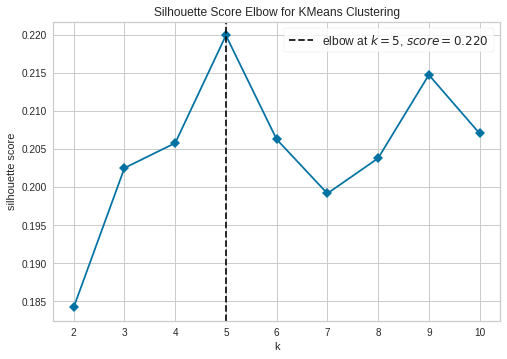

In [ ]:
# Silhouette Coefficient
cls = KMeans(random_state=122)
visualizer = KElbowVisualizer(cls, k=(2,11), metric='silhouette', timings=False)
visualizer.fit(X_scaled) 
plt.xticks(range(2,11))
visualizer.show()
plt.show()

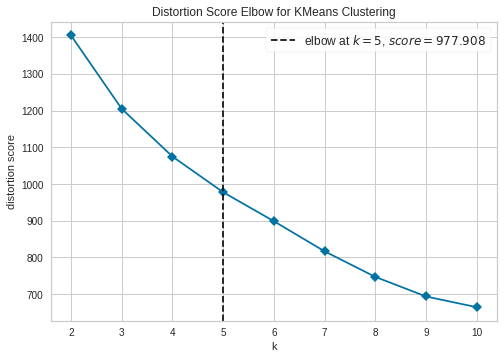

In [ ]:
# Méthode du coude
visualizer = KElbowVisualizer(cls, k=(2,11), timings=False)
visualizer.fit(X_scaled)
plt.xticks(range(2,11))
visualizer.show()  
plt.show()

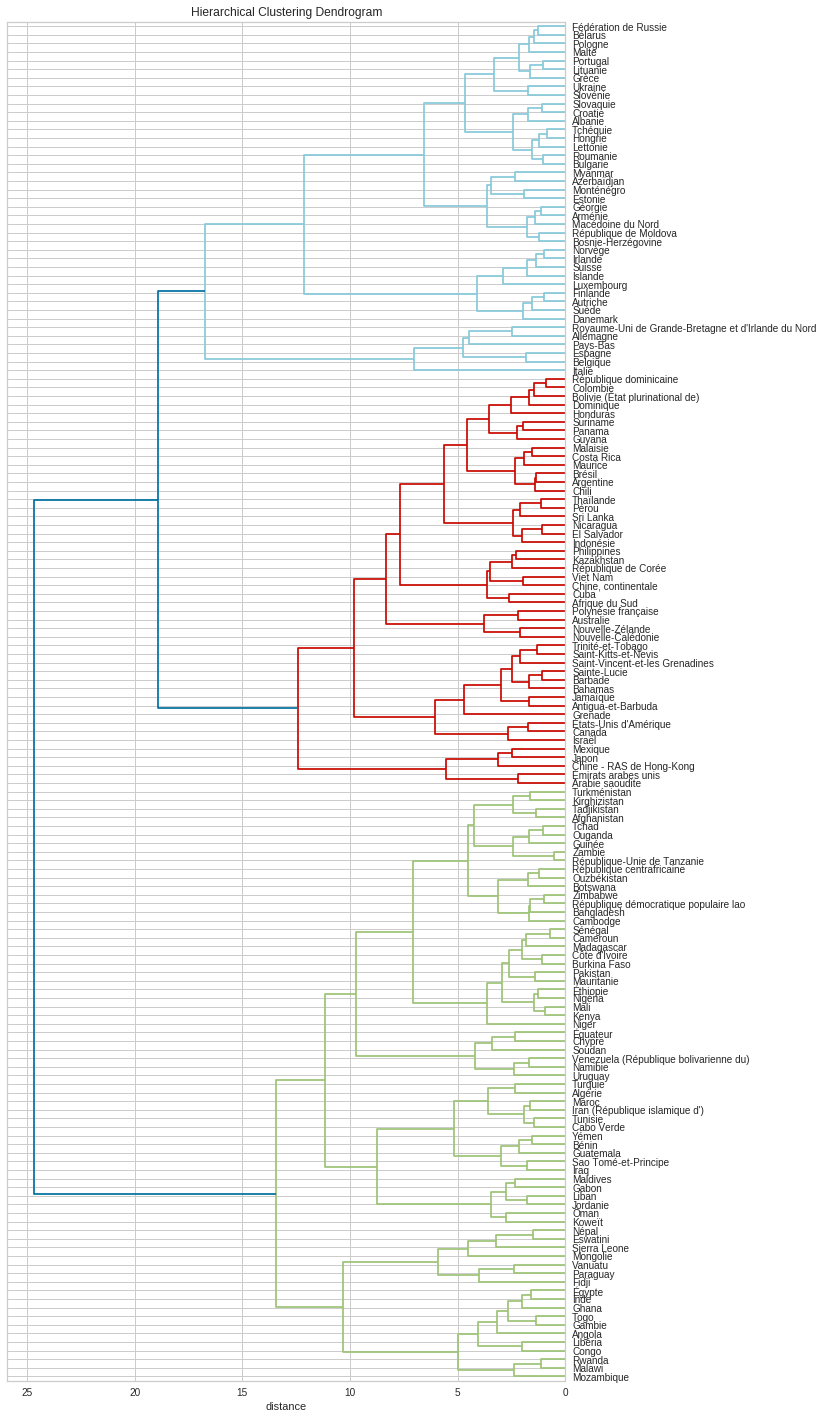

In [ ]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
plt.figure(figsize=(10,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(Z, labels = y, orientation = "left", leaf_font_size=10, distance_sort='ascending')
plt.show()

La Méthode du Coude et le Silhouette Coefficient distinguent 5 clusters. On va diviser les pays en 5 clusters avec la k-means méthode.

### **3. Clustering**<a class="anchor" id="section_2_3"></a>

In [ ]:
cls = KMeans(n_clusters=5, random_state=122)
cls.fit(X_scaled)

KMeans(n_clusters=5, random_state=122)

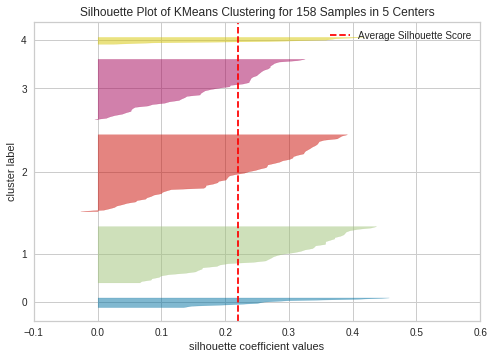

In [ ]:
visualizer = SilhouetteVisualizer(cls, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()
plt.show()

Il y a les clusters que l'on vient de construire : les clusters 0 et 4 sont les plus petits (contiennent le plus petit nombre de pays). Le cluster 2 est le plus grand. 
Comme on a déjà vu le coefficient de silhouette (égal à la distance de séparation entre les clusters résultants) = 0,22. Cette valeur indique que les clusters sont proches de la limite de décision entre les clusters voisins. On n'a pas de clusters bien distingués.

### **4. Comparaison et sélection de clusters**<a class="anchor" id="section_2_4"></a>

In [ ]:
# on ajoute à la base de données une colonne avec les numéros des clusters correspondants
chicken_food['Cluster']=cls.labels_.astype(str)

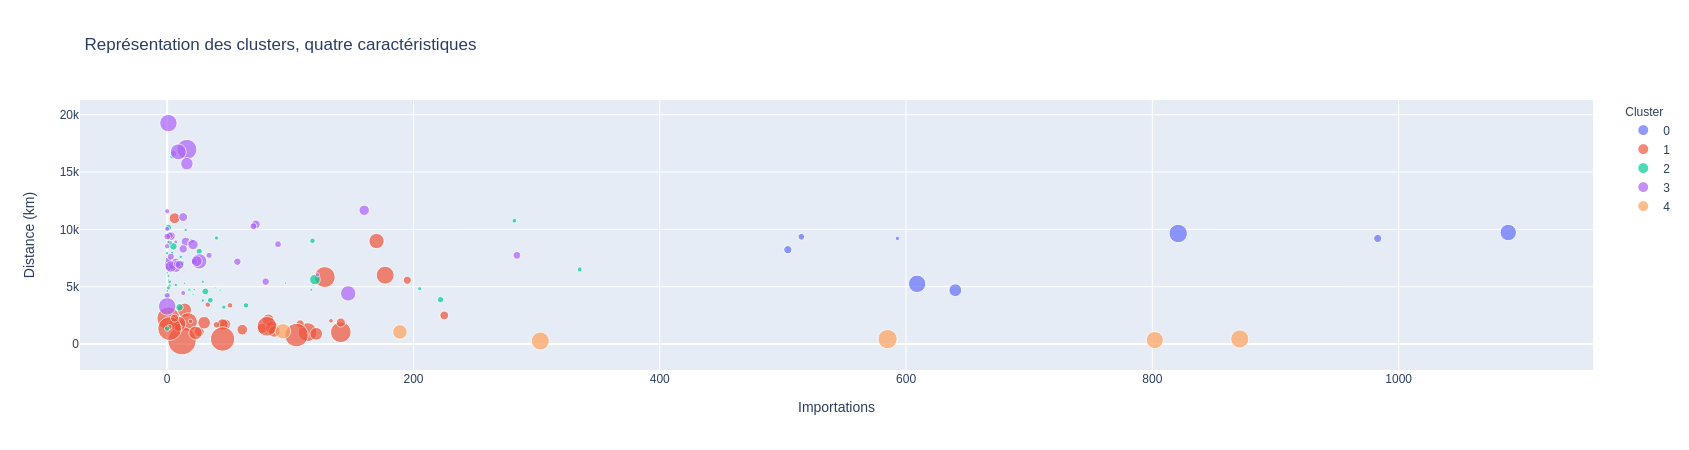

In [ ]:
# un graphique qui montre les distances, les importations, les PIB/hab et les numéros de cluster par pays
fig1 = px.scatter(chicken_food, x="Importations", y=chicken_food["Distance"]*(-1), color="Cluster", size="PIB/hab", hover_name=chicken_food.index,  
                  labels={"y": "Distance (km)", "x": "Importations de Viande de Volailles (milliers de tonnes)"},
                  category_orders={"Cluster": ["0", "1", "2", "3", "4"]},
                  title="Représentation des clusters, quatre caractéristiques")
fig1.show()

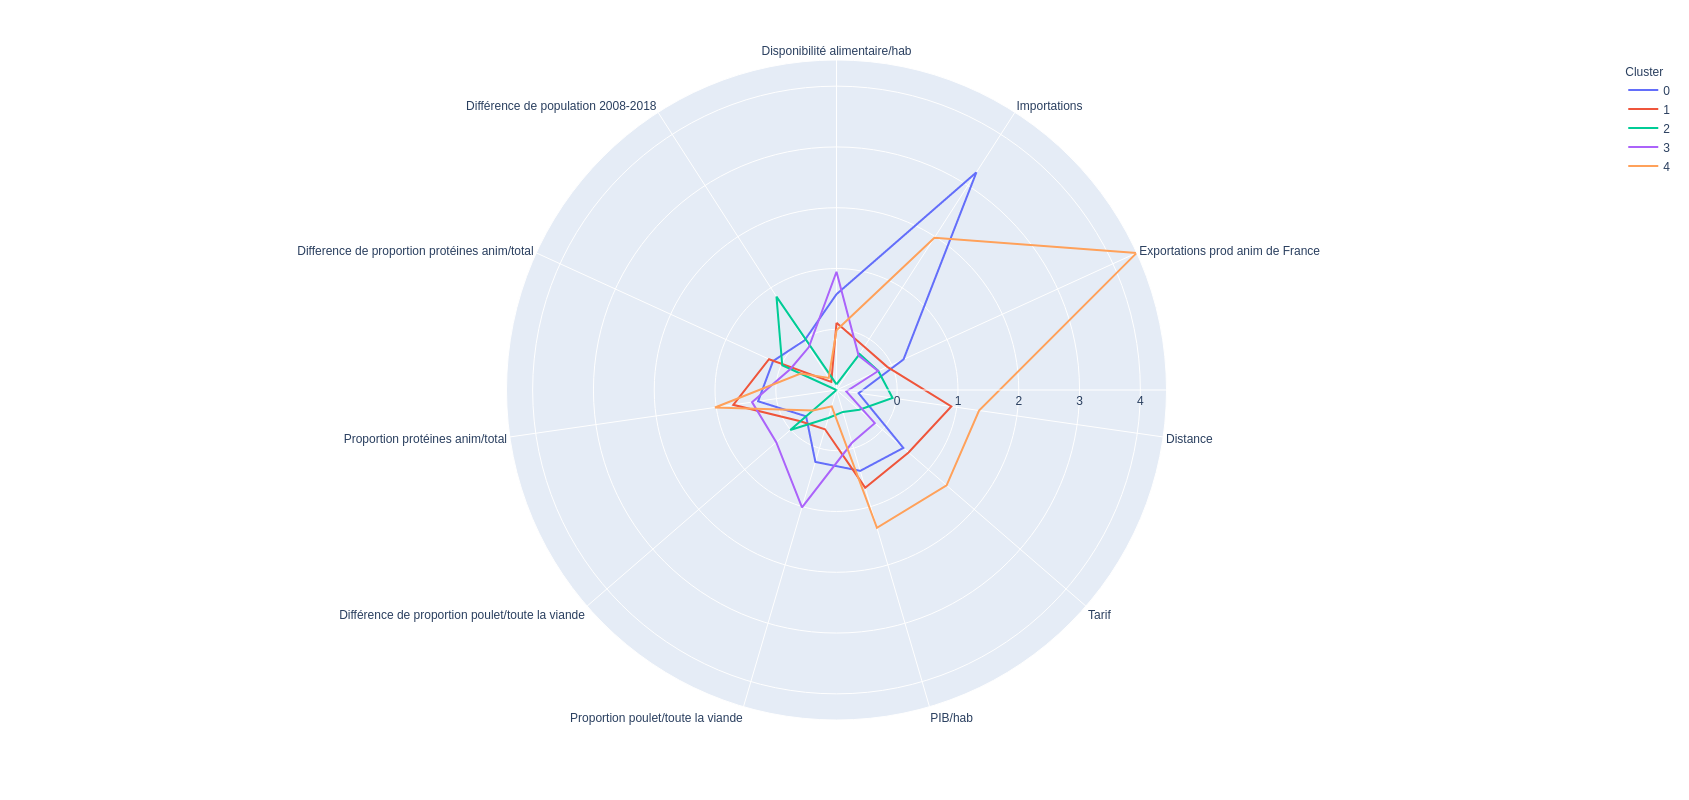

In [ ]:
# un graphiqie pour voir comment les clusters ont été déterminés
clusters=pd.DataFrame(X_scaled, index=y, columns=chicken_food.drop(columns='Cluster').columns)
clusters['Cluster']=cls.labels_
polar=clusters.groupby("Cluster").mean().reset_index()
polar=pd.melt(polar,id_vars=["Cluster"])
fig = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=800,width=1400)
fig.show()

Un petit rappel : on a multiplié les colonnes 'Distance' et 'Tarif' par -1. <br>
Les valeurs les plus attractives de toutes les variables sont toujours celles les plus élevés.

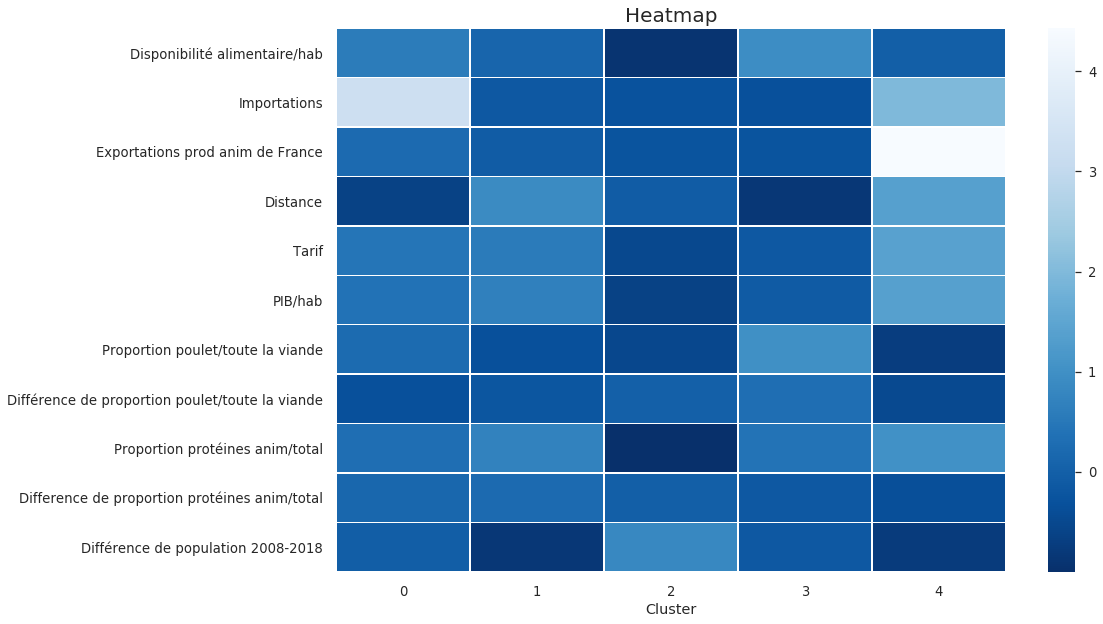

In [ ]:
#heatmap
scaled_df=pd.DataFrame(X_scaled, index=y, columns=chicken_food.drop(columns='Cluster').columns)
scaled_df['Cluster']=cls.labels_
heatmap_df=scaled_df.groupby("Cluster").mean().transpose()
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Heatmap', fontsize=20)
ax = sns.heatmap(heatmap_df, linewidths=.5, cmap= "Blues_r")
#plt.savefig('P9_02_heatmap.png', transparent=False, bbox_inches='tight')

**Nous avons 5 clusters :**<br>
**cluster 0** : les pays-importateurs de viande de volailles qui se trouvent assez loin de France. Il y a des flux commerciaux entre la France et ces pays, mais la France n'est pas leur principal fournisseur. Ce cluster pourrait être intéressant pour notre entreprise à l'avenir, lorsqu'elle souhaite développer considérablement ses ventes. Une étude approfondie du marché, des lois et des normes de qualité de ces pays sera requise dans ce cas. Probablement, si on établit un commerce avec ces pays on ne pourra exporter que la viande congelée.<br>
**cluster 1** : les pays assez riches, avec une grande proportion de protéines d'origine animale qui grandit avec le temps. Ces pays sont accessibles grâce à leur proximité géographique et les tarifs assez bas. Pourtant, ils n'importent pas trop de viande de volailles et préfèrent d'autres catégories de viande. Très probablement, ces pays produisent assez de viande pour la consommation intérieure. Car les conditions pour un commerce sont favorables, on peut essayer d'entrer sur le marché si on propose des prix attractifs.<br>
**cluster 2** : ce cluster contient les pays les plus pauvres avec le taux de croissance démographique le plus élevé. Le PIB par habitant, la disponibilité de viande de volailles, la proportion de protéines d'origine animale par rapport à la quantité totale de protéines sont les plus petits. En outre, les tarifs (les coûts supplémentaires) sont les plus élevés et ces pays se trouvent assez loin de la France. Ce cluster est, donc, le moins attractif pour nous.<br>
**cluster 3** : les pays qui privilégient la viande de volailles aux autres catégories de viande. La disponibilité de viande de volailles par habitant est la plus élevée pour ces pays ainsi que la proportion de cette viande par rapport à la consommation alimentaire de viande totale. De plus, cette proportion grandit avec le temps (le taux de croissance de cet indicateur sur 10 ans est le plus élevé parmi tous les clusters). Pourtant, ces pays sont les plus éloignés de la France, les coûts supplémentaires sont assez grands. On peut conclure que ce cluster pourrait être intéressant pour une entreprise d'un pays plus proche de ces pays.<br> 
**cluster 4** : les pays-importateurs de viande de volailles qui se trouvent à côté de la France, ces pays sont caractérisés par le niveau du PIB par habitant le plus élevé ainsi que par la plus grande proportion de protéines d'origine animale. Les coûts supplémentaires d'exportation sont les plus petits pour la France. Ces pays exportent la plus grande partie de produits d'origine animale de la France. On peut deviner qu'il y a un commerce bien établit entre la France et ces pays, ainsi que les divers accords commerciaux. Ce cluster nous intéresse le plus, car il est préférable pour une nouvelle entreprise de commencer par des marchés de vente bien établis : ces pays sont satisfaits de la qualité des produits d'origine animale qu'ils importent de France, la loi et la culture de ces pays sont similaires à celles en France, les barrières géographiques sont surmontables. De plus, on peut exporter la viande fraîche à ces pays, grâce à leur proximité.

In [ ]:
clusters_countries=[[], [], [], [], []]
for i in clusters.index:
    clusters_countries[clusters.loc[i]['Cluster'].astype(int)]+=[i]
clusters_countries=['; '.join(clusters_countries[0]), '; '.join(clusters_countries[1]), '; '.join(clusters_countries[2]), '; '.join(clusters_countries[3]), '; '.join(clusters_countries[4])]
table=pd.DataFrame(clusters_countries, index=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4'], columns=['Liste des pays'])
table['Priorité']=["3", "2", "pas d'intêret", "pas d'intêret", "1"]
table.sort_values('Priorité')

Liste des pays       Priorité
cluster 4  Allemagne; Belgique; Espagne; Italie; Pays-Bas...              1
cluster 1  Albanie; Arménie; Autriche; Bosnie-Herzégovine...              2
cluster 0  Afrique du Sud; Arabie saoudite; Chine - RAS d...              3
cluster 2  Afghanistan; Algérie; Angola; Azerbaïdjan; Ban...  pas d'intêret
cluster 3  Antigua-et-Barbuda; Argentine; Australie; Baha...  pas d'intêret

#### **Analyse des prix de la viande de poulet en 2018**

Les prix du poulet n'ont pas été inclus dans l'analyse car on ne disposait de données que pour ~50 pays. 

In [ ]:
prices=pd.read_csv('prix_2018.csv', header=0)
prices.set_index('Zone', inplace=True)
prices['Cluster']=chicken_food['Cluster']
tariff['Cluster']=chicken_food['Cluster']

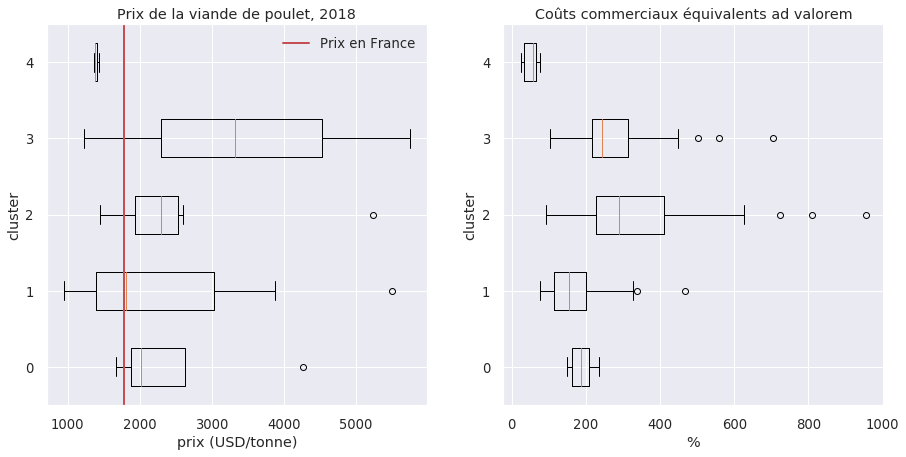

In [ ]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(121)
ax.boxplot([prices[prices['Cluster']=='0']['Valeur'],
            prices[prices['Cluster']=='1']['Valeur'],
            prices[prices['Cluster']=='2']['Valeur'],
            prices[prices['Cluster']=='3']['Valeur'],
            prices[prices['Cluster']=='4']['Valeur']], vert=False)
ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])
plt.axvline(prices.loc['France']['Valeur'], color='r', linewidth=2)
plt.title('Prix de la viande de poulet, 2018')
plt.xlabel('prix (USD/tonne)')
plt.ylabel('cluster')
plt.legend(handles=[mlines.Line2D([], [], color='r', linewidth=2, markersize=15, label="Prix en France")])

ax = fig.add_subplot(122)
ax.boxplot([tariff[tariff['Cluster']=='0']['Trcost from France'],
            tariff[tariff['Cluster']=='1']['Trcost from France'],
            tariff[tariff['Cluster']=='2']['Trcost from France'],
            tariff[tariff['Cluster']=='3']['Trcost from France'],
            tariff[tariff['Cluster']=='4']['Trcost from France']], vert=False)
ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])
plt.title('Coûts commerciaux équivalents ad valorem')
plt.xlabel('%')
plt.ylabel('cluster')

plt.show()

Dans les pays du **cluster 4** les prix de la viande de poulet sont les plus bas, en revanche, les coûts commerciaux sont également les plus bas. Il faut comparer le prix de consommation avec la somme du prix de revient et des coûts commerciaux pour calculer le profit potentiel.<br>
Aux prix un peu plus élevés du **cluster 0** correspondent des coûts un peu plus élevés également. <br>
Le **cluster 1** est moins prévisible, les fourchettes du prix et des coûts commerciaux sont plus grandes. Pourtant, on voit que la moitie des pays de ce cluster ont les prix de la viande de poulet plus élevés qu'en France. Donc, il est possible d'entrer ce marché si nos prix sont assez bas.<br>
Le **cluster 2** est même moins attractif pour nous après cette analyse : les prix dans ces pays sont bas, tandis que les coûts commerciaux sont élevés. Donc, le profit potentiel sera petit.<br>
On n'est pas non plus intéressé par le **cluster 3**, pourtant la fourchette du prix pour les pays de ce cluster est la plus grande. Cela est dû au fait que ce cluster contient le plus grand nombre de pays.

## **Mission 3. Représentation des clusters** <a class="anchor" id="chapter3"></a>

### **1. ACP**<a class="anchor" id="section_3_1"></a>

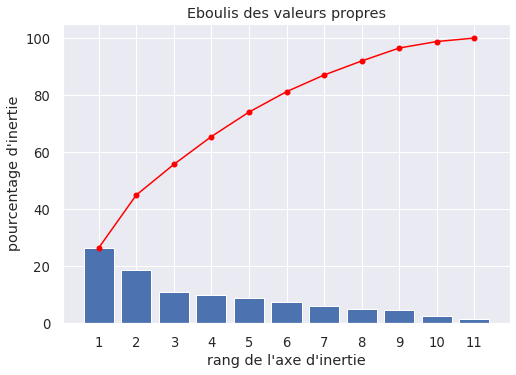

In [ ]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=len(chicken_food.columns)-1)
pca.fit(X_scaled)
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.xticks(range(1, len(chicken_food.columns)))
plt.show(block=False)

Notre échantillon n'a pas de structure visible, les variables n’ont presque pas de corrélation entre elles. Cela a à voir avec le choix des variables qui ont été choisies pour représenter les pays de la manière la plus polyvalente. La projection du nuage des individus sur le premier plan factoriel ne représente que 45% de l’inertie totale. L'ajoute des F3 et F4 ne change pas trop la situation : on aura 65,5% de l’inertie totale expliquée. Je peux conclure que les axes synthétiques ne sont pas suffisants pour une analyse approfondie de nos pays et des clusters.<br>
Pourtant, il peut être intéressant de visualiser le nuage des individus pour savoir quelles variables séparent un pays d'un autre le plus. Donc, on va projeter les données sur le premier plan factoriel.

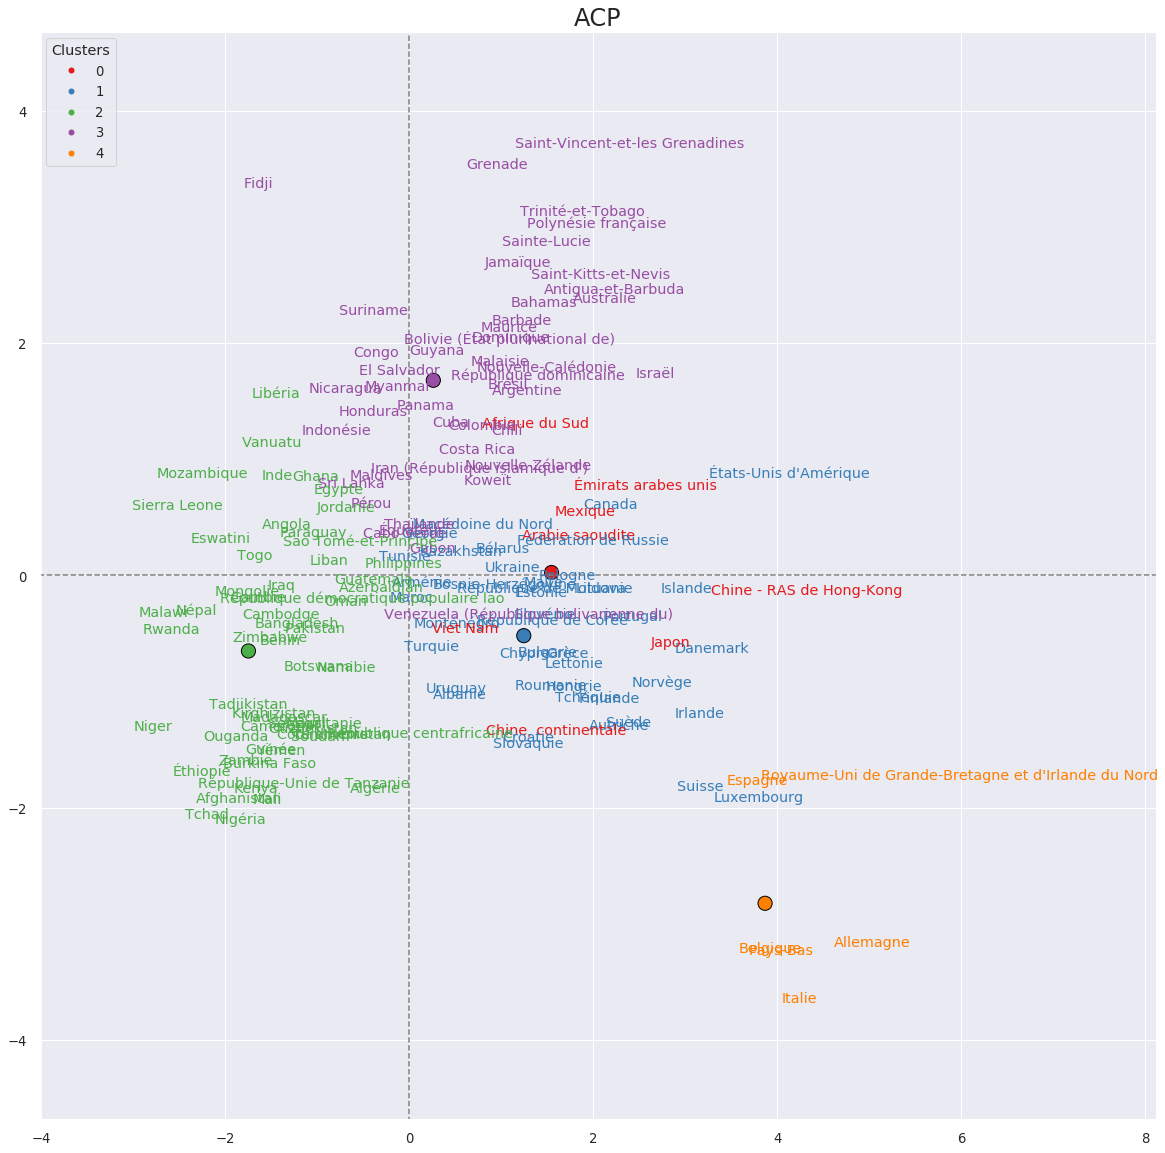

In [ ]:
X_projected = pca.transform(X_scaled)
centroids = cls.cluster_centers_
centroids_projected=pca.transform(centroids)
fig=plt.figure(figsize=(20,20))

colors = np.array([(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0),
                   (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
                   (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0),
                   (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0),
                   (1.0, 0.4980392156862745, 0.0, 1.0)])

for i in range(X.shape[0]):
    plt.text(X_projected[i, 0], X_projected[i, 1], str(y[i]), color=colors[cls.labels_[i]])
plt.xlim([np.min(X_projected[:, 0])-1, np.max(X_projected[:, 0])+3.5])
plt.ylim([np.min(X_projected[:, 1])-1, np.max(X_projected[:, 1])+1])
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')
plt.scatter(centroids_projected[:,0] , centroids_projected[:,1] , s = 200, c=colors, cmap='Set1', marker='o', edgecolors='black')

line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[0], linewidth=0)
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[1], linewidth=0)
line3 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[2], linewidth=0)
line4 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[3], linewidth=0)
line5 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[4], linewidth=0)
plt.legend((line1, line2, line3, line4, line5),(0, 1, 2, 3, 4), numpoints=1, loc='upper left', frameon=True, title='Clusters')
plt.title('ACP', fontsize=24)
plt.show()

Les clusters sont très proches les uns des autres (en particulier, les clusters 0 et 1 : leurs centroïdes sont les plus proches)). Ils se croisent. Cette situation est tout à fait normale, car il n'existe pas de pays identiques ou tellement semblables qu'ils n'ont rien en commun avec les autres. Dans notre base de données, il existe au moins une caractéristique commune à presque chaque paire de pays.

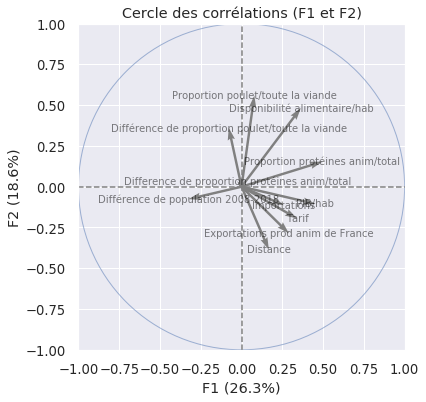

In [ ]:
pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1),(2,3), (4,5)], labels = np.array(chicken_food.columns))

La variable synthétique **F1** compare les pays selon leur richesse : à droite on a les pays où la disponibilité alimentaire et le PIB par habitant, ainsi que la proportion de protéines d'origine animale, sont les plus élevés ; à gauche on a les pays où le taux de croissance démographique est le plus élevé (les pays où il n'y a pas eu de transition démographique).<br>
La variable synthétique **F2** nous montre la répartition des pays selon leur proximité de la France et leur accessibilité pour la France : les pays en bas du graphique sont les plus proches, avec une grande partie d'exportations françaises et des coûts supplémentaires bas. 

### **2. Visualisation de la struction locale des données (t-SNE)**<a class="anchor" id="section_3_2"></a>

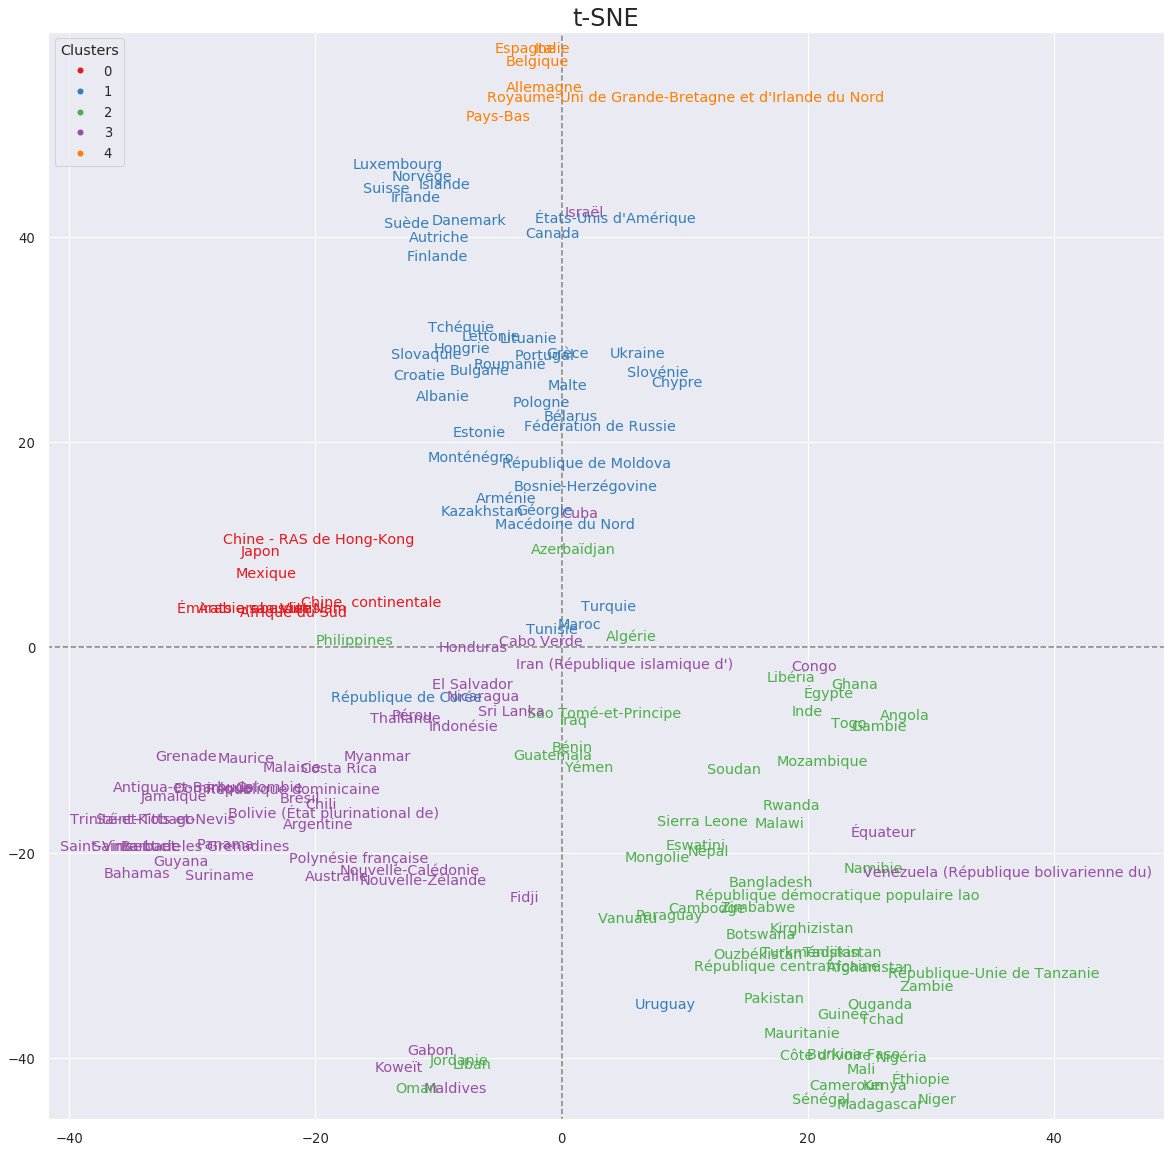

In [ ]:
# on visualise analyse la struction locale du phenomène
#init='pca' pour conserver de base un peu plus de la structure globale
tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=3000, init='pca')
X_tsne = tsne.fit_transform(X_scaled)
fig=plt.figure(figsize=(20,20))
colors = np.array([(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0),
                   (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
                   (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0),
                   (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0),
                   (1.0, 0.4980392156862745, 0.0, 1.0)])
for i in range(X.shape[0]): 
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]), color=colors[cls.labels_[i]])
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')
plt.xlim([np.min(X_tsne[:, 0])-1, np.max(X_tsne[:, 0])+20])
plt.ylim([np.min(X_tsne[:, 1])-1, np.max(X_tsne[:, 1])+2])

line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[0], linewidth=0)
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[1], linewidth=0)
line3 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[2], linewidth=0)
line4 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[3], linewidth=0)
line5 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[4], linewidth=0)
plt.legend((line1, line2, line3, line4, line5),(0, 1, 2, 3, 4), numpoints=1, loc='upper left', frameon=True, title='Clusters')
plt.title('t-SNE', fontsize=24)
plt.show()

La structure locale de l'échantillon représentent les clusters dans une meilleure façon. On voit clairement les clusters 0 et 4. Les autres se croisent plus, mais néanmoins la plupart d'entre eux sont concentrés dans des espaces spécialement désignés pour eux.

### **3. Visualisation de la struction globale des données (MDS)**<a class="anchor" id="section_3_3"></a>

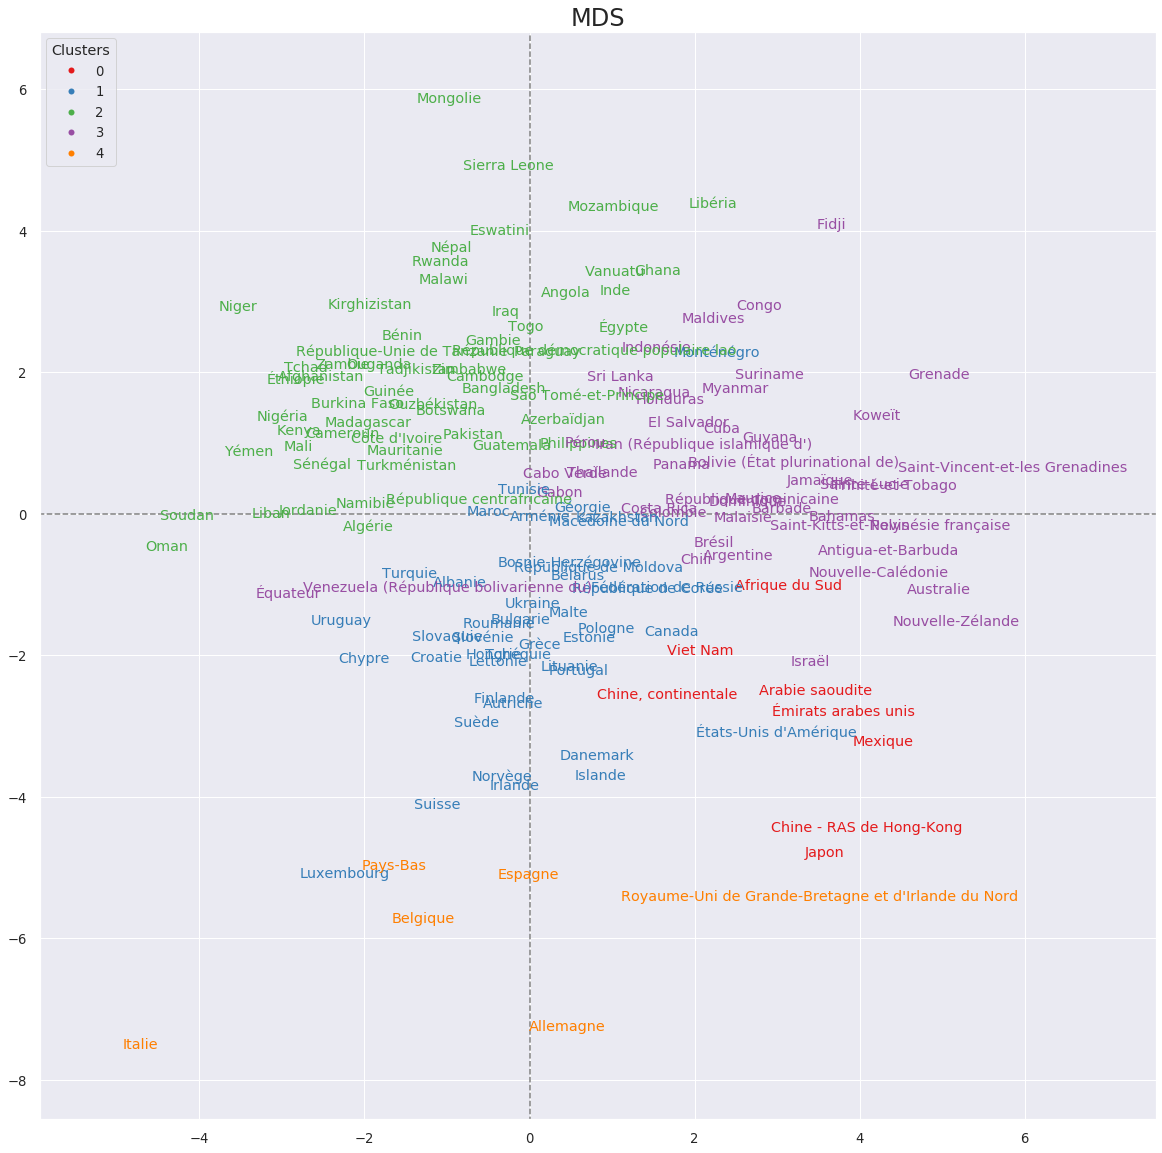

In [ ]:
# on visualise et analyse la structure globale du phénomène
mds=manifold.MDS()
X_mds = mds.fit_transform(X_scaled)
fig=plt.figure(figsize=(20,20))
colors = np.array([(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0),
                   (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
                   (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0),
                   (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0),
                   (1.0, 0.4980392156862745, 0.0, 1.0)])
for i in range(X.shape[0]):
    plt.text(X_mds[i, 0], X_mds[i, 1], str(y[i]), color=colors[cls.labels_[i]])
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')
plt.xlim([np.min(X_mds[:, 0])-1, np.max(X_mds[:, 0])+3])
plt.ylim([np.min(X_mds[:, 1])-1, np.max(X_mds[:, 1])+1])
line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[0], linewidth=0)
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[1], linewidth=0)
line3 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[2], linewidth=0)
line4 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[3], linewidth=0)
line5 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[4], linewidth=0)
plt.legend((line1, line2, line3, line4, line5),(0, 1, 2, 3, 4), numpoints=1, loc='upper left', frameon=True, title='Clusters')
plt.title('MDS', fontsize=24)
plt.show()

La structure globale de l'échantillon nous montre à nouveau à quel point les individus sont proches.

### **4. Visualisation des clusters à l'aide d'une carte**<a class="anchor" id="section_3_4"></a>

In [ ]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [ ]:
# on traduit les noms de pays en anglais pour unir le tableau avec les clusters et le tableau avec les coordonnées géographiques
countries_trans.reset_index(inplace=True)
countries_trans.set_index('name_fr', inplace=True)
chicken_food_geom=chicken_food.copy()
chicken_food_geom['eng']=countries_trans['name_eng']

In [ ]:
# on fusionne ces deux tableaux et supprime les données dont on n'a pas de besoin
world=pd.merge(world, chicken_food_geom.reset_index(), how='left', left_on='name', right_on='eng')
world.drop(columns=['Zone', 
                    'Disponibilité alimentaire/hab', 
                    'Importations',
                    'Proportion poulet/toute la viande',
                    'Différence de proportion poulet/toute la viande', 
                    'Différence de population 2008-2018',
                    'Distance',
                    'Proportion protéines anim/total',
                    'Difference de proportion protéines anim/total',
                    'PIB/hab', 
                    'Tarif',
                    'Exportations prod anim de France',
                    'eng'], inplace=True)

In [ ]:
# on a besoin de marquer la France sur la carte
world.loc[world['name']=='France', 'Cluster']='France'

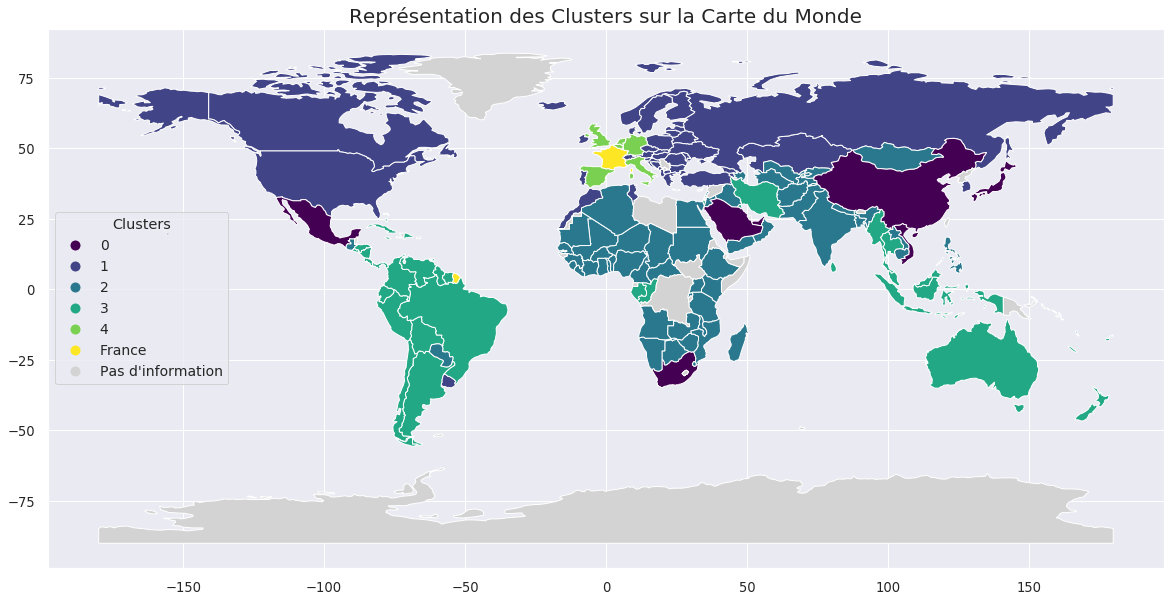

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(column='Cluster',
           ax=ax,  
           missing_kwds={"color": "lightgrey", "label": "Pas d'information"}, # on affiche les valeurs manquantes en gris
           cmap='viridis', 
           legend=True, 
           legend_kwds={'frameon': True, 'loc': 'center left', 'title': 'Clusters', 'fontsize': 14})
plt.title('Représentation des Clusters sur la Carte du Monde', fontsize=20)
plt.show()

## **Conclusion** <a class="anchor" id="chapter4"></a>

En utilisant les 11 variables suivantes :<br>
1. La quantité d'importation de Viande de Volailles par pays (en milliers de tonnes)<br>
2. La valeur des exportations de produits d'origine animale de France par pays pour 2018 (en milliers US dollars)<br>
3. Les distances entre la France et les autres pays (régions) (en kilomètres)<br>
4. Les coûts supplémentaires (en pourcentage) <br>
5. Le PIB par habitant (en US dollars) <br>
6. La proportion de Viande de Volailles par rapport à la consommation alimentaire de viande totale (en pourcentage)<br>
7. Sa différence entre 2008 et 2018 (en pourcentage) <br>
8. La proportion de protéines d'origine animale par rapport à la quantité totale de protéines (en pourcentage) <br>
9. Sa différence entre 2008 et 2018 (en pourcentage) <br>
10. La différence de population entre 2008 et 2018 (en pourcentage)<br>
11. La disponibilité alimentaire de Viande de Volailles en quantité (kg/personne/an),<br>
on a construit 5 clusters de 158 pays.

Pourtant, le coefficient de silhouette (égal à la distance de séparation entre les clusters résultants) = 0,22. Cette valeur indique que les clusters sont proches de la limite de décision entre les clusters voisins. On n'a, donc, pas de clusters bien distingués. Les clusters sont très proches les uns des autres (en particulier, les clusters 0 et 1 : leurs centroïdes sont les plus proches)). Ils se croisent. 
Cette situation est tout à fait normale, car il n'existe pas de pays identiques ou tellement semblables qu'ils n'ont rien en commun avec les autres. Dans notre base de données, il existe au moins une caractéristique commune à presque chaque paire de pays.

Le premier plan principal du nuage de données distingue les pays selon leur richesse (F1) et selon leur proximité de la France et leur accessibilité pour la France (F2). Les variables qui font partie de ces variables synthétiques définissent la structure de nos données dans l'espace.


**cluster 0** : les pays-importateurs de viande de volailles qui se trouvent assez loin de France. Il y a des flux commerciaux entre la France et ces pays, mais la France n'est pas leur principal fournisseur. Ce cluster pourrait être intéressant pour notre entreprise à l'avenir, lorsqu'elle souhaite développer considérablement ses ventes. Une étude approfondie du marché, des lois et des normes de qualité de ces pays sera requise dans ce cas. Probablement, si on établit un commerce avec ces pays on ne pourra exporter que la viande congelée. Aux prix un peu plus élevés correspondent des coûts un peu plus élevés également.


**cluster 1** : les pays assez riches, avec une grande proportion de protéines d'origine animale qui grandit avec le temps. Ces pays sont accessibles grâce à leur proximité géographique et les tarifs assez bas. Pourtant, ils n'importent pas trop de viande de volailles et préfèrent d'autres catégories de viande. Très probablement, ces pays produisent assez de viande pour la consommation intérieure. Les fourchettes du prix et des coûts commerciaux sont assez grandes. Pourtant, on voit que la moitie des pays de ce cluster ont les prix de la viande de poulet plus élevés qu'en France. Car les conditions pour un commerce sont favorables, on peut essayer d'entrer sur le marché si on propose des prix attractifs. 


**cluster 2** : ce cluster contient les pays les plus pauvres avec le taux de croissance démographique le plus élevé. Le PIB par habitant, la disponibilité de viande de volailles, la proportion de protéines d'origine animale par rapport à la quantité totale de protéines sont les plus petits. En outre, les tarifs (les coûts supplémentaires) sont les plus élevés, les prix de la viande de poulet sont bas, ces pays se trouvent assez loin de la France. Ce cluster est, donc, le moins attractif pour nous.


**cluster 3** : les pays qui privilégient la viande de volailles aux autres catégories de viande. La disponibilité de viande de volailles par habitant est la plus élevée pour ces pays ainsi que la proportion de cette viande par rapport à la consommation alimentaire de viande totale. De plus, cette proportion grandit avec le temps (le taux de croissance de cet indicateur sur 10 ans est le plus élevé parmi tous les clusters). Pourtant, ces pays sont les plus éloignés de la France, les coûts supplémentaires sont assez grands. La fourchette du prix pour les pays de ce cluster est la plus grande. Cela est dû au fait que ce cluster contient le plus grand nombre de pays. On peut conclure que ce cluster pourrait être intéressant pour une entreprise d'un pays plus proche de ces pays. 


**cluster 4** : les pays-importateurs de viande de volailles qui se trouvent à côté de la France, ces pays sont caractérisés par le niveau du PIB par habitant le plus élevé ainsi que par la plus grande proportion de protéines d'origine animale. Les coûts supplémentaires d'exportation sont les plus petits pour la France. Ces pays exportent la plus grande partie de produits d'origine animale de la France. On peut deviner qu'il y a un commerce bien établit entre la France et ces pays, ainsi que les divers accords commerciaux. Ce cluster nous intéresse le plus, car il est préférable pour une nouvelle entreprise de commencer par des marchés de vente bien établis : ces pays sont satisfaits de la qualité des produits d'origine animale qu'ils importent de France, la loi et la culture de ces pays sont similaires à celles en France, les barrières géographiques sont surmontables. De plus, on peut exporter la viande fraîche à ces pays, grâce à leur proximité. Dans les pays de ce cluster les prix de la viande de poulet sont les plus bas, en revanche, les coûts commerciaux sont également les plus bas. Il faut comparer le prix de consommation avec la somme du prix de revient et des coûts commerciaux pour calculer le profit potentiel.

On a, donc, choisi 3 groupements de pays que l’on pourrait cibler pour exporter des poulets : les clusters 0, 1 et 4.

Pour l'avenir proche ce sont les pays du cluster 4 (Allemagne; Belgique; Espagne; Italie; Pays-Bas; Royaume-Uni de Grande-Bretagne et d'Irlande du Nord) seulement qui nous intéressent. Les clusters 1 (42 pays) et le cluster 0 (8 pays) ne sont pas inaccessibles non plus, mais ils requissent une analyse de marché plus approfondie et une réputation établie. 